In [211]:
import sys
from typing import List, Dict, Tuple
from data_tools import task_map, row_operations
from utils import persistence as ps
from urllib3.response import HTTPResponse
from pandas import DataFrame, Series, read_csv, concat, Grouper, melt, merge_asof, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, cpu_count
from error_handling import errors
from scipy import stats
from geo_merger import geo_merge, EXT
from numpy import array, empty, float64, zeros_like, triu_indices_from, log, nan, inf, asarray
from time import sleep
from functools import reduce

In [212]:
import warnings
warnings.filterwarnings('ignore')

In [213]:
RGTRANSIT_BUCKET: str = 'rg-transit'
RGFARES_BUCKET: str = 'rg-tsfare'
RGGCABS_BUCKET: str = 'rg-gcabs'
RGYCABS_BUCKET: str = 'rg-ycabs'
RGTRAFFIC_BUCKET: str = 'rg-traffic'
REFBASE_BUCKET: str = 'ref-base'
GEOMERGED_PATH: str = 'geo-merged/'
PLOTS_BUCKET: str = 'plots'

MIN_INVW= 1 / 9.5
MAX_INVW = 1 / 0.5
RELPLOT_SZ_MULT = 1.5

BASE_COLOR='#34495E'
COLOR1='#E74C3C'
COLOR2='#2ECC71'

In [214]:
station_complex_map: Dict[str, str] = {
                                'BOWERY': 'BOWERY STREET-DELANCEY ST',
                                'WALL ST': 'WALL STREET',
                                'COURT SQ': 'COURT SQ',
                                '86 ST': '86TH STREET-4TH AVENUE',
                                'SOUTH FERRY': 'WHITEHALL STREET'
                              }
station_map: Dict[str, int] = {
                                'BOWERY': 103,
                                'WALL ST': 413,
                                'COURT SQ': 274,
                                '86 ST': 397,
                                'SOUTH FERRY': 330
                              }
weekday_map: Dict[int, str] = {
                                0 : 'Monday',
                                1 : 'Tuesday',
                                2 : 'Wednesday',
                                3 : 'Thursday',
                                4 : 'Friday',
                                5 : 'Saturday',
                                6 : 'Sunday'
                              }


In [215]:
geomerged_cabs: str = GEOMERGED_PATH+'/cabs.csv'
geomerged_traffic: str = GEOMERGED_PATH+'/traffic.csv'

# load ref-base geomerged files
filestream: HTTPResponse = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_cabs)
dtypes: Dict[str, str] = {
    'stop_name': 'object',
    'tsstation': 'object',
    'locationid': 'int64',
    'weight': 'float64'
}
geomerged_cabs_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_cabs_df = geomerged_cabs_df[~geomerged_cabs_df['locationid'].isna()]
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_traffic)
dtypes = {
    'stop_name': 'object',
    'tsstation': 'object',
    'linkid': 'float64',
    'weight': 'float64'
}
geomerged_traffic_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_traffic_df = geomerged_traffic_df[~geomerged_traffic_df['linkid'].isna()]

In [216]:
task = 'pl-1W-16-17'
freq = '1D'
filterby ='all'
filterval = ''
stations = ['BOWERY', 'WALL ST', 'COURT SQ', '86 ST', 'SOUTH FERRY']
station = stations[1]

In [217]:
range_: List[str] = task_map.task_type_map[task]['range']
start_date: str = range_[0]
end_date: str = range_[1]
# determine filename of transit data for
# the current station in the rg-transit bucket
# replace '/' in station with ' '
file_path: str = freq+'/'+filterby+filterval+'/'
ts_filename: str = file_path+station.replace('/', ' ').upper()

# read transit data for station (rg-transit bucket)
filestream = ps.get_file_stream(bucket=RGTRANSIT_BUCKET, filename=ts_filename)
ts_datecols = ['datetime']
dtypes = {
         'delex': 'int64',
         'delent': 'int64'
        }
transit_df = read_csv(filestream, usecols=ts_datecols + list(dtypes.keys()),
                                 parse_dates=ts_datecols,
                                 date_parser=row_operations.parse_rg_dt,
                                 encoding='utf-8', dtype=dtypes)
transit_df = transit_df.set_index('datetime').resample(freq).sum().loc[start_date: end_date]
transit_df.head()

delex  delent
datetime                 
2016-01-01   9225   12190
2016-01-02   9084   12386
2016-01-03   8290    9832
2016-01-04  21336   27878
2016-01-05  24183   29831

In [218]:
def weighted_mean(group, weight_col):
    data_cols = [col for col in group.columns if col != weight_col]
    group_result = Series(empty(len(data_cols)), index=data_cols, dtype=float64)
    total_weight = group[weight_col].sum()
    for col in data_cols:
        group_result[col] = (group[col] * group[weight_col]).sum() / total_weight
    return group_result

In [219]:
cabs_datecols = ['dodatetime']

# determine relevant cabs files
# by finding dolocationids corresponding
# to current station from ref-base geomerged df
dolocationids = geomerged_cabs_df.loc[geomerged_cabs_df.tsstation == station][['locationid', 'weight']]

cabs_dtypes = {
    'dolocationid': 'int64',
    'passengers': 'int64',
    'distance': 'float64'
}

gcabs_df: DataFrame
gcabs_df = concat([read_csv(ps.get_file_stream(bucket=RGGCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGGCABS_BUCKET, path=file_path)],
                   ignore_index=True)
gcabs_df = gcabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left', copy=False).\
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()

#gcabs_df = gcabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#
gcabs_df = gcabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]
gcabs_df.head()

passengers   distance
dodatetime                       
2016-01-01   12.997514  26.730037
2016-01-02   12.072977  22.568372
2016-01-03   11.383797  22.045298
2016-01-04   12.559591  21.286322
2016-01-05   12.067423  21.081923

In [220]:
ycabs_df: DataFrame
ycabs_df = concat([read_csv(ps.get_file_stream(bucket=RGYCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGYCABS_BUCKET, path=file_path)],
                  ignore_index=True)
ycabs_df = ycabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left',
                          copy=False). \
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()
#ycabs_df = ycabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq='D', level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#                                                                                                 'weight': 'first'}).loc[
#           start_date: end_date]
ycabs_df = ycabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

ycabs_df.head()

passengers     distance
dodatetime                         
2016-01-01   37.098466    70.927643
2016-01-02   46.104289    82.708230
2016-01-03   41.876620    85.435436
2016-01-04   47.522867  1943.225535
2016-01-05   49.660423   225.116662

In [221]:
traffic_df: DataFrame
traffic_datecols = ['datetime']
linkids = geomerged_traffic_df.loc[geomerged_traffic_df.tsstation == station][['linkid', 'weight']]

if linkids.size > 0:
    traffic_dtypes = {
        'linkid': 'int64',
        'speed': 'float64',
        'traveltime': 'float64'
    }
    traffic_cols = list(traffic_dtypes.keys())
    traffic_df = concat([read_csv(ps.get_file_stream(bucket=RGTRAFFIC_BUCKET, filename=file_path+str(int(linkid))),
                                  header=0,
                                  usecols=traffic_datecols + traffic_cols,
                                  parse_dates=traffic_datecols,
                                  encoding='utf-8', dtype=traffic_dtypes)
                        for linkid in linkids['linkid']
                       if str(int(linkid)) in ps.get_all_filenames(bucket=RGTRAFFIC_BUCKET, path=file_path)],
                      ignore_index=True)
    traffic_df = traffic_df.merge(linkids, on='linkid', how='left', copy=False).drop(columns=['linkid']).drop_duplicates()
    #traffic_df = traffic_df.set_index(traffic_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'speed': 'mean',
    #                                                                                                'traveltime': 'mean',
    #
    traffic_df = traffic_df.set_index(traffic_datecols).groupby(Grouper(freq=freq, level=0)).\
                apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

traffic_df.head()

speed  traveltime
datetime                         
2016-01-01  45.742034  138.480422
2016-01-02  44.023684  151.110483
2016-01-03  44.635034  153.356573
2016-01-04  41.335783  170.452128
2016-01-05  41.328925  178.088024

In [222]:
# gas
gas_file: str ='gas.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=gas_file)
dtypes = {
    'price': 'float64'
}
gas_datecols = ['date']
gas_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+gas_datecols, parse_dates=gas_datecols, encoding='utf-8', dtype=dtypes)
gas_df = gas_df.set_index(gas_datecols).loc[start_date: end_date]
# drop outliers
gas_df = row_operations.drop_outliers(gas_df, 'price')
# gas data is weekly reported on Mondays
# shift dates from Monday to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
# shift back by one day
#td = Timedelta(-1, unit='d')
#gas_df.index = gas_df.index + td
gas_df.head()

price
date             
2016-01-04  2.147
2016-01-11  2.123
2016-01-18  2.056
2016-01-25  2.027
2016-02-01  1.997

In [223]:
ix = DatetimeIndex(start=start_date, end=end_date, freq='D')
gas_df = gas_df.reindex(ix).interpolate(method='linear', limit_direction='both')
gas_df.head()

price
2016-01-01  2.147000
2016-01-02  2.147000
2016-01-03  2.147000
2016-01-04  2.147000
2016-01-05  2.143571

In [224]:
# weather
weather_file: str ='weather.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=weather_file)
dtypes = {
        'prcp': 'float64',
        'snow': 'float64',
        'temp': 'float64'
}
weather_datecols = ['date']
weather_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+weather_datecols, parse_dates=weather_datecols, encoding='utf-8', dtype=dtypes)
weather_df = weather_df.set_index(weather_datecols).loc[start_date: end_date]
# weather data is daily
# filter by day (filterby and filterval)
#print(filterval)
#weather_df = weather_df.loc[weather_df.index.dayofweek == int(filterval)]
# shift dates from filterval day to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
#td = Timedelta(-1-int(filterval), unit='d')
#weather_df.index = weather_df.index + td
weather_df.head()

prcp  snow  temp
date                        
2016-01-01   0.0   0.0  38.0
2016-01-02   0.0   0.0  36.0
2016-01-03   0.0   0.0  40.0
2016-01-04   0.0   0.0  25.0
2016-01-05   0.0   0.0  20.0

In [225]:
cabs_df= DataFrame()
cabs_df['passengers'] = gcabs_df['passengers'] + ycabs_df['passengers']
cabs_df['distance'] = gcabs_df['distance'] + ycabs_df['distance']

In [226]:
df_merged = concat([transit_df, cabs_df, traffic_df, gas_df, weather_df], axis=1)
df_merged.head()

delex   delent  passengers     distance      speed  traveltime  \
2016-01-01   9225.0  12190.0   50.095981    97.657679  45.742034  138.480422   
2016-01-02   9084.0  12386.0   58.177266   105.276602  44.023684  151.110483   
2016-01-03   8290.0   9832.0   53.260417   107.480734  44.635034  153.356573   
2016-01-04  21336.0  27878.0   60.082458  1964.511857  41.335783  170.452128   
2016-01-05  24183.0  29831.0   61.727846   246.198585  41.328925  178.088024   

               price  prcp  snow  temp  
2016-01-01  2.147000   0.0   0.0  38.0  
2016-01-02  2.147000   0.0   0.0  36.0  
2016-01-03  2.147000   0.0   0.0  40.0  
2016-01-04  2.147000   0.0   0.0  25.0  
2016-01-05  2.143571   0.0   0.0  20.0

In [227]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         729 non-null float64
delent        729 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         626 non-null float64
traveltime    626 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


In [228]:
len(df_merged.loc[df_merged.isna().any(axis=1).values])

107

In [229]:
#df_merged = df_merged.dropna()
df_merged = df_merged.interpolate(method='linear', limit_direction='both')
len(df_merged.loc[df_merged.isna().any(axis=1).values])

0

In [230]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         731 non-null float64
delent        731 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         731 non-null float64
traveltime    731 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


#### Stationarity tests

In [231]:
sns.set_style('darkgrid')

In [232]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(15,6))
    orig = ax.plot(timeseries, color='blue',label='Original')
    mean = ax.plot(rolmean, color='red', label='Rolling Mean')
    std = ax.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [233]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [234]:
def make_acf_plot(series, lag=50):
    fig, ax = plt.subplots(2,1, figsize=(15,12))
    plot_acf(series, ax=ax[0], lags=lag)
    plot_pacf(series, ax=ax[1], lags=lag)
    plt.show()
    return

In [235]:
def make_hist_plot(series):
    fig, ax = plt.subplots(figsize=(15,6))
    hist = ax.hist(series, bins=50)
    plt.show()
    return    

In [236]:
def make_ts_plots(series, lag=50):
    test_stationarity(series)
    make_hist_plot(series)
    make_acf_plot(series, lag)
    return

### Transit Passengers (exiting the station)

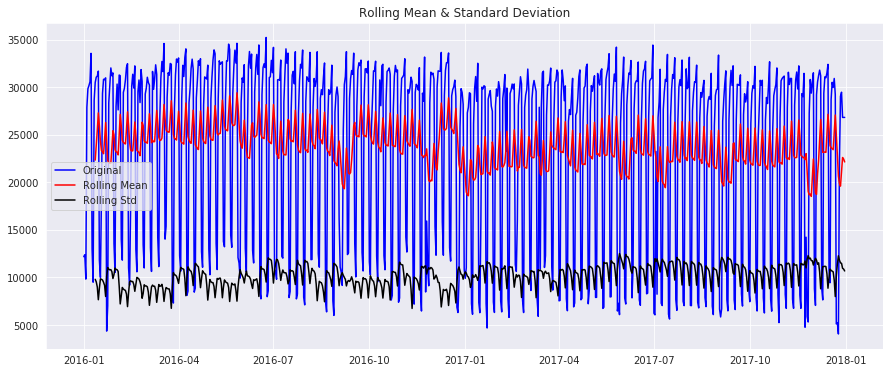

Results of Dickey-Fuller Test:
Test Statistic                  -4.158597
p-value                          0.000774
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


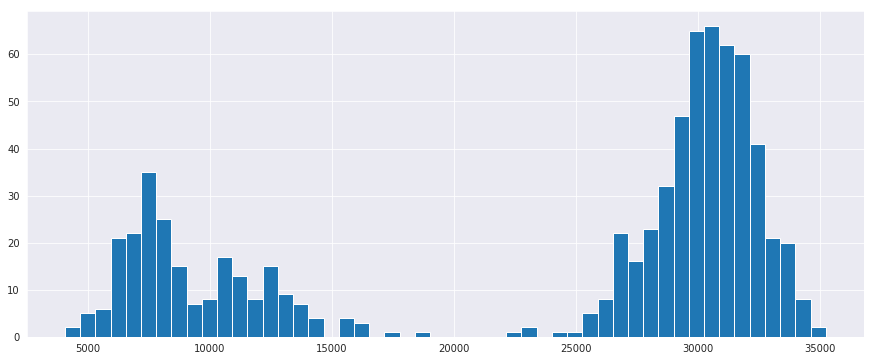

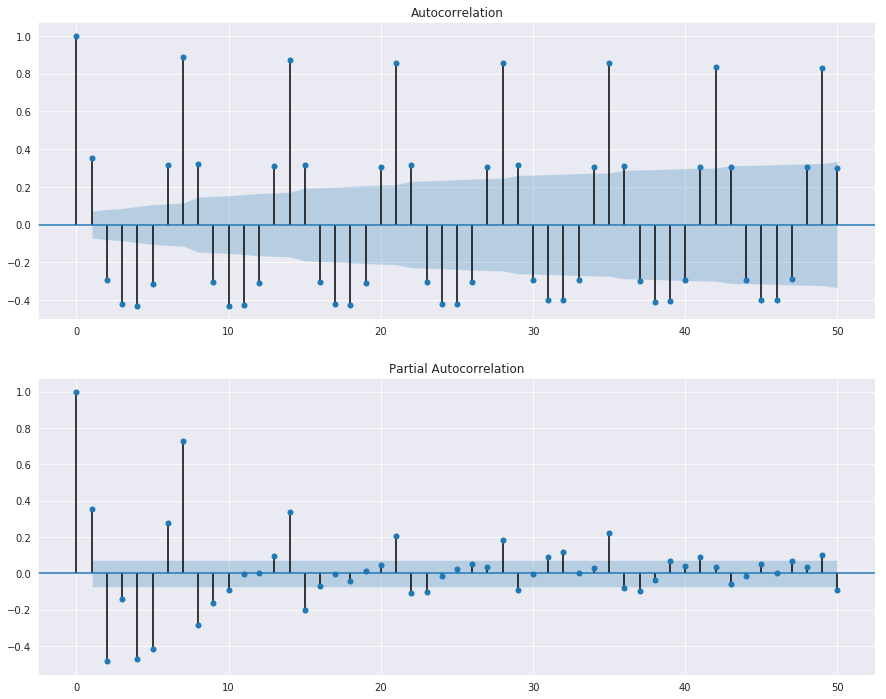

In [237]:
make_ts_plots(df_merged['delent'])

#### Local Trend

In [238]:
from pyflux import LLT
delex_llt_model = LLT(data=df_merged, target='delex')
delex_llt_model.fit()
delex_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Transit Passengers (entering the station)

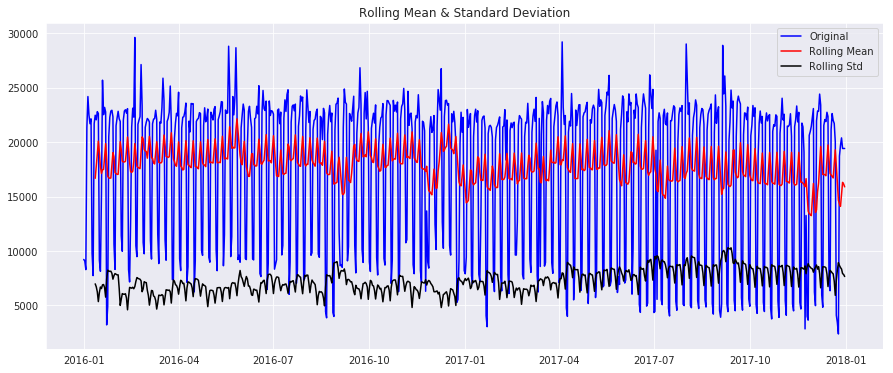

Results of Dickey-Fuller Test:
Test Statistic                  -4.346754
p-value                          0.000368
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


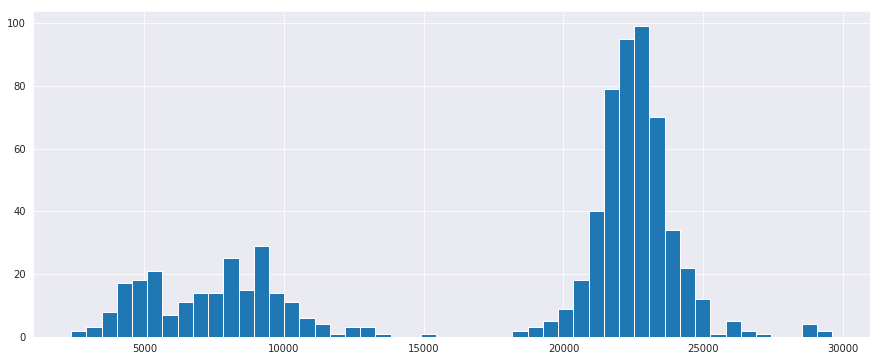

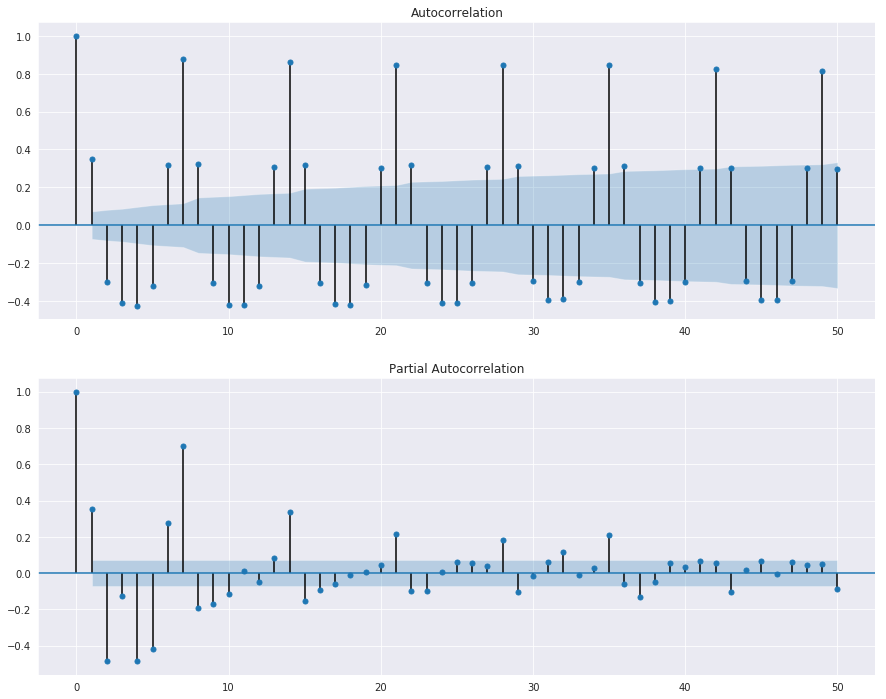

In [239]:
make_ts_plots(df_merged['delex'])

#### Local Trend

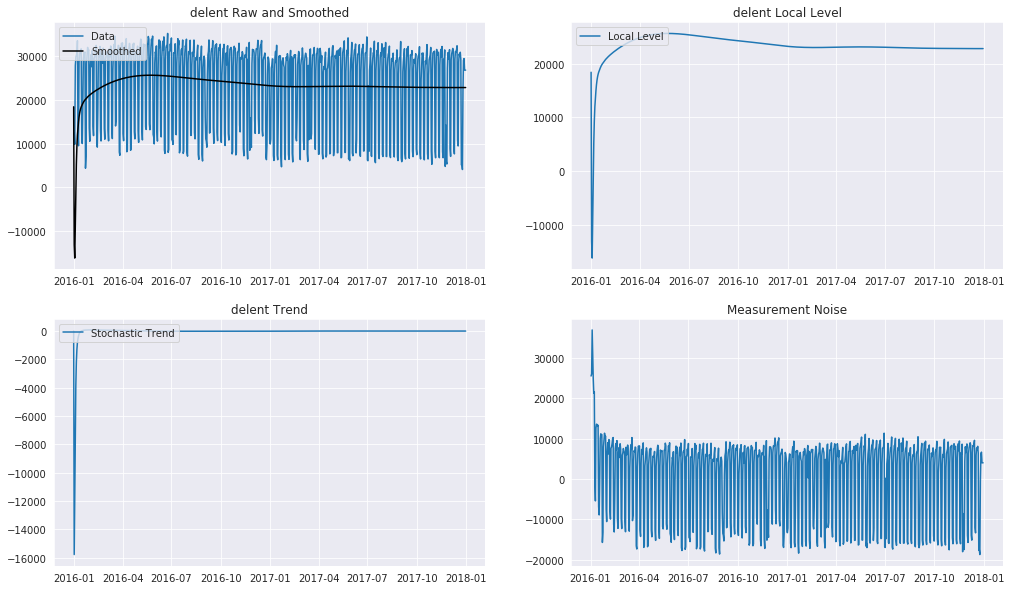

In [240]:
delent_llt_model = LLT(data=df_merged, target='delent')
delent_llt_model.fit()
delent_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Cab Rides

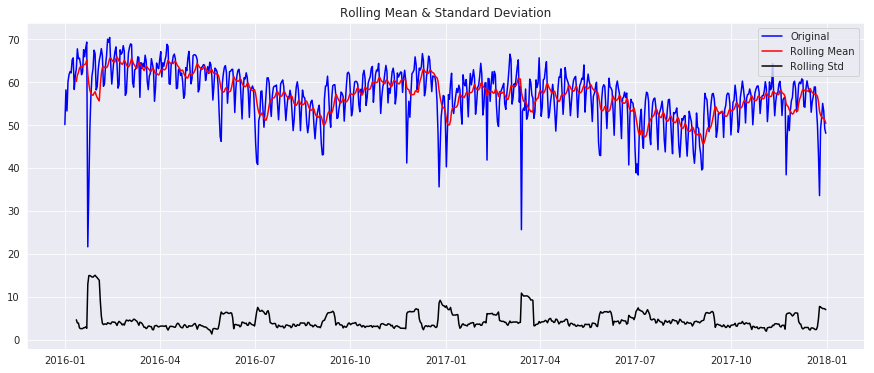

Results of Dickey-Fuller Test:
Test Statistic                  -2.457215
p-value                          0.126234
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


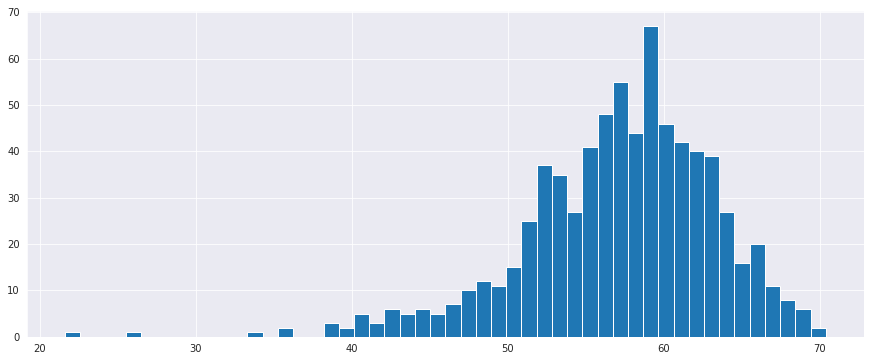

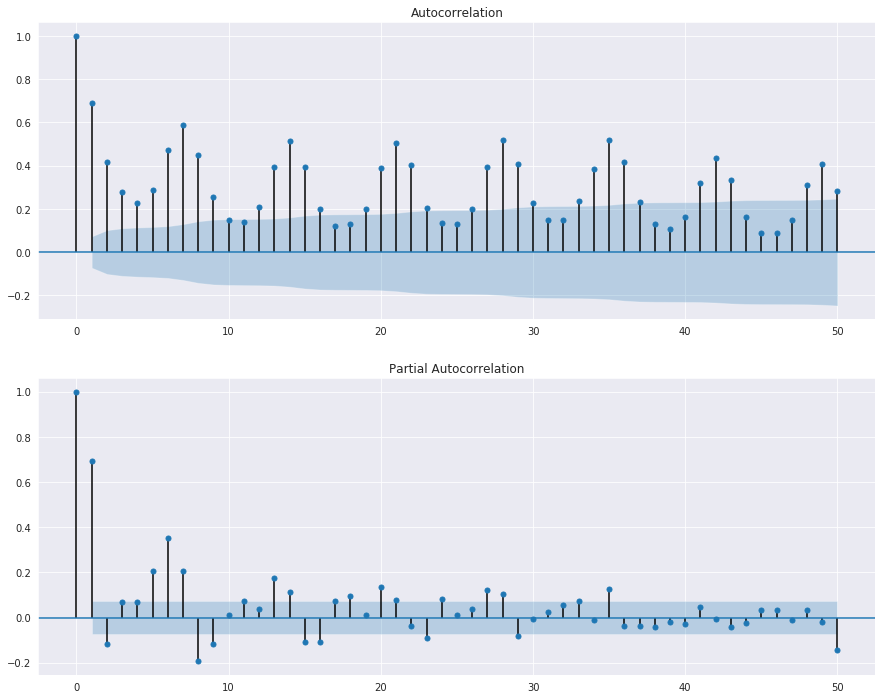

In [241]:
make_ts_plots(df_merged['passengers'])

#### Local Trend

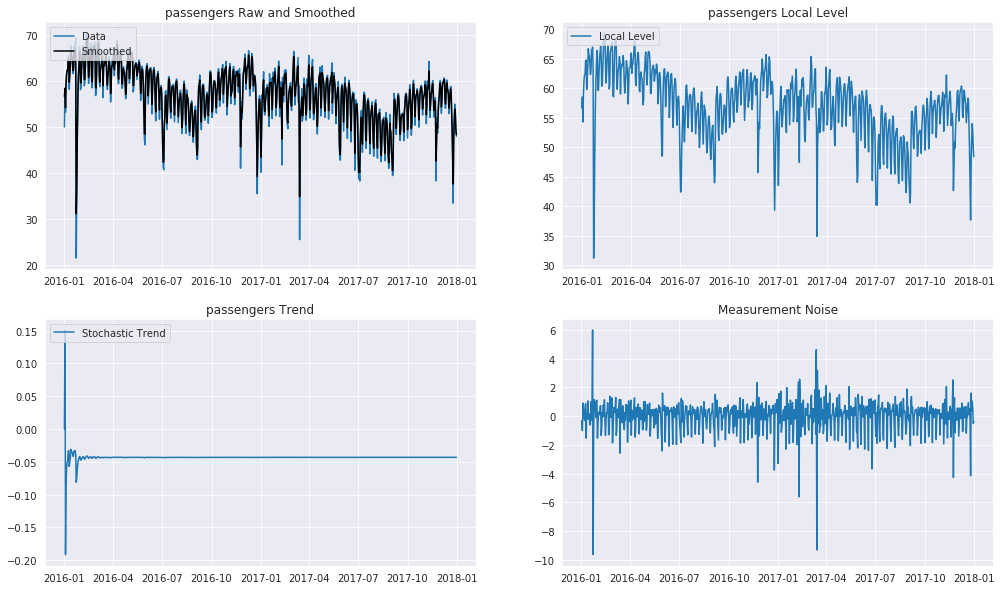

In [242]:
#cabs_llt_model = LLT(data=df_merged, target='passengers')
cabs_llt_model = LocalTrend(data=df_merged, integ=0, target='passengers', family=Normal())
cabs_llt_model.fit()
cabs_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Traffic Speed

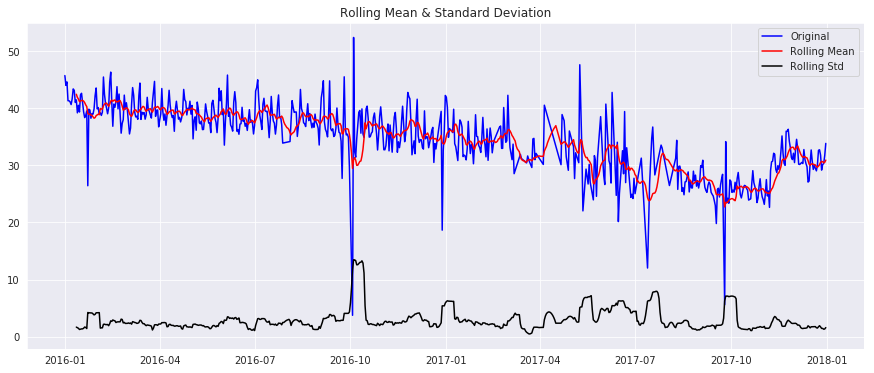

Results of Dickey-Fuller Test:
Test Statistic                  -2.204295
p-value                          0.204690
#Lags Used                      13.000000
Number of Observations Used    717.000000
Critical Value (1%)             -3.439503
Critical Value (5%)             -2.865579
Critical Value (10%)            -2.568921
dtype: float64


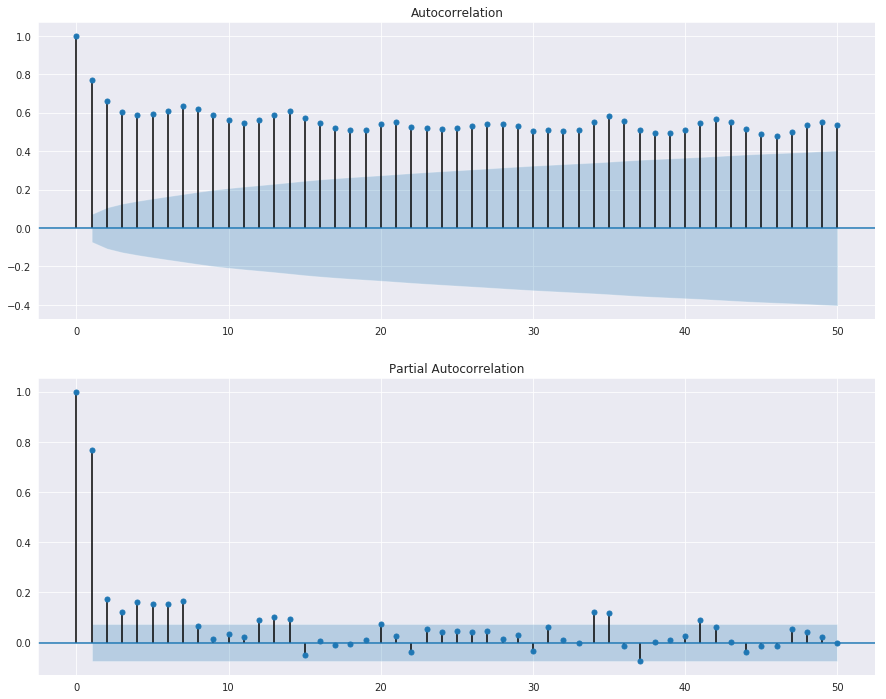

In [243]:
make_ts_plots(df_merged['speed'])

#### Local Trend

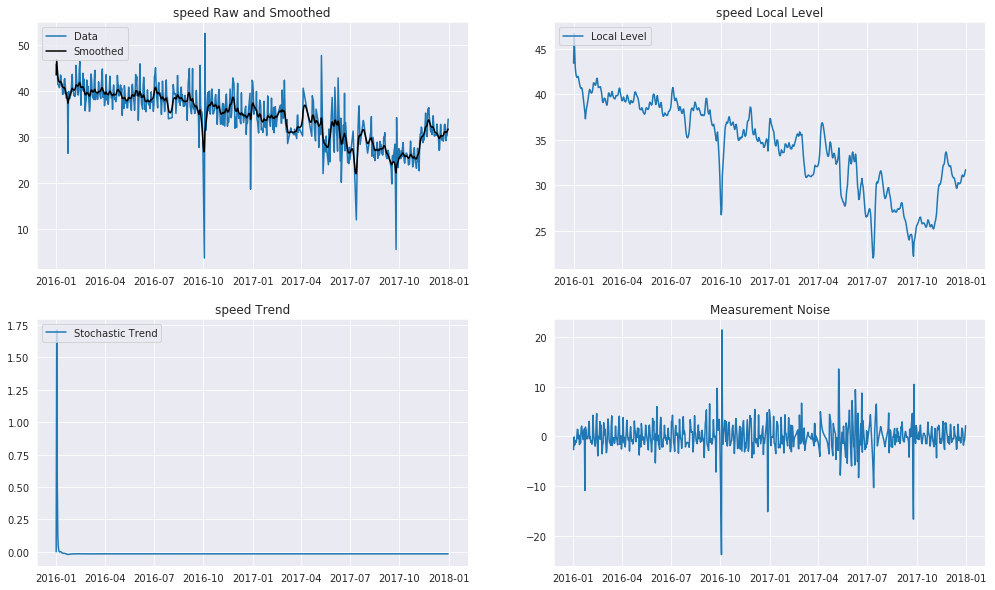

In [244]:
#traffic_llt_model = LLT(data=df_merged, target='speed')
traffic_llt_model = LocalTrend(data=df_merged, integ=0, target='speed', family=Normal())
traffic_llt_model.fit()
traffic_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Gas Price

Results of Dickey-Fuller Test:
Test Statistic                  -1.954157
p-value                          0.307028
#Lags Used                      15.000000
Number of Observations Used    715.000000
Critical Value (1%)             -3.439529
Critical Value (5%)             -2.865591
Critical Value (10%)            -2.568927
dtype: float64


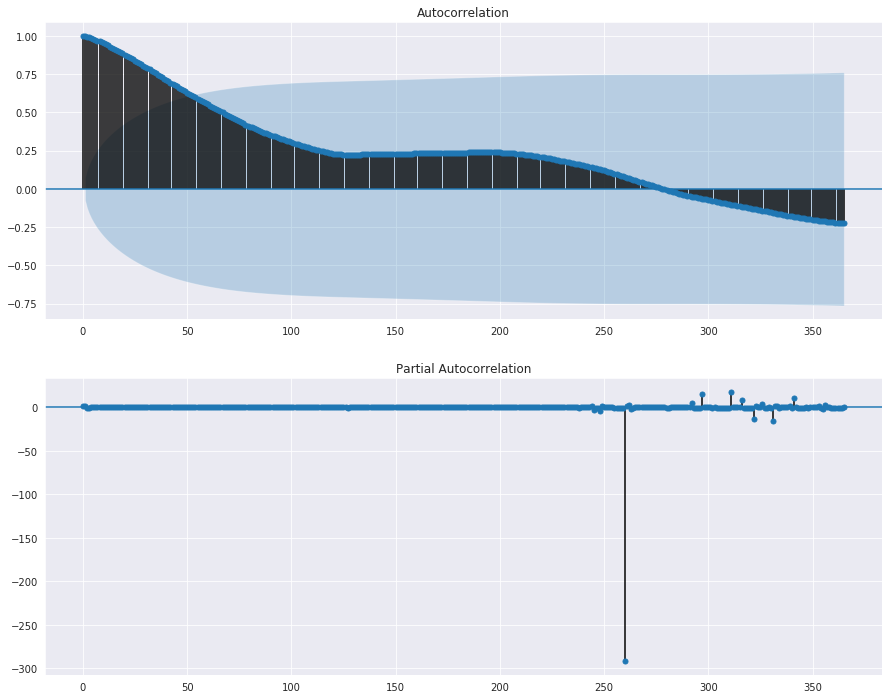

In [245]:
make_ts_plots(df_merged['price'], lag=365)

#### Local Trend

In [246]:
from pyflux import LocalTrend, Normal
def find_local_trend(data, target_col, max_integ=3, family=Normal()):
    aic = []
    loglik = []
    for integ in range(max_integ+1):
        llt_model = LocalTrend(data=data, integ=integ, target=target_col, family=family)
        llt_model_result = llt_model.fit()
        aic.append(llt_model_result.aic)
        loglik.append(llt_model_result.loglik)
    opt_integ = aic.index(min(aic))
    print(aic)
    print(loglik)
    return opt_integ

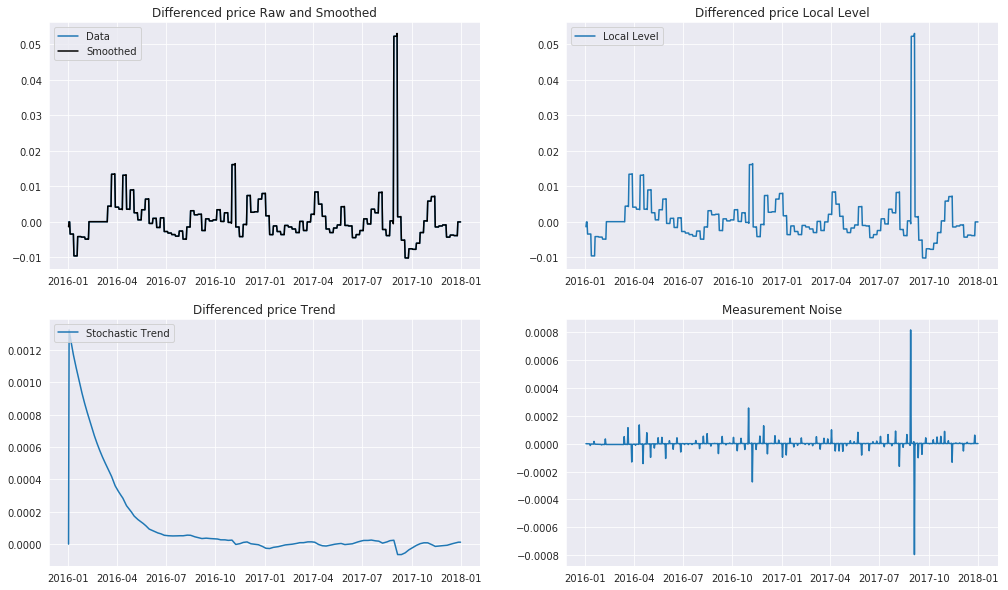

In [247]:
#gas_integ = find_local_trend(data=df_merged, target_col='price', max_integ=3, family=Normal())
gas_llt_model = LocalTrend(data=df_merged, integ=1, target='price', family=Normal())
gas_llt_model_result = gas_llt_model.fit()
gas_llt_model.plot_fit(intervals=False,figsize=(17,10))

In [248]:
gas_llt_model_result.summary()

LLT                                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced price                   Method: MLE                                       
Start Date: 2016-01-01 00:00:00                         Log Likelihood: 3135.8459                         
End Date: 2017-12-31 00:00:00                           AIC: -6265.6917                                   
Number of observations: 730                             BIC: -6251.9126                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        4.2e-09                                                          
Sigma^2 level                        

### Weather Temperature

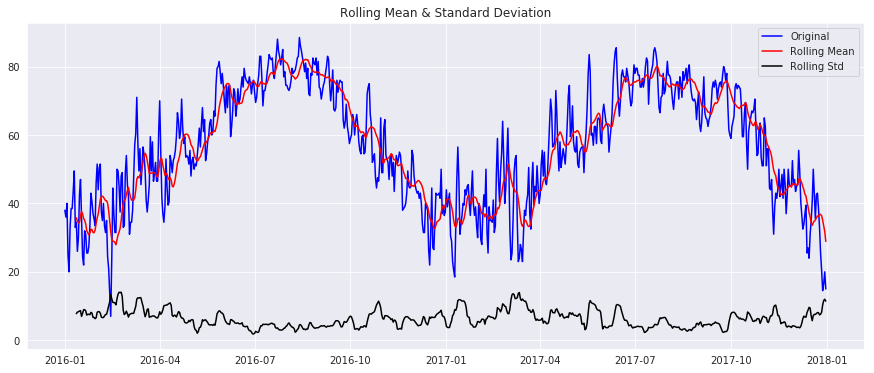

Results of Dickey-Fuller Test:
Test Statistic                  -1.220396
p-value                          0.664761
#Lags Used                      14.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


In [249]:
make_ts_plots(df_merged['temp'], lag=365)

#### Local Trend

In [250]:
weather_llt_model = LocalTrend(data=df_merged, integ=0, target='temp', family=Normal())
weather_llt_model.fit()
weather_llt_model.plot_fit(intervals=False,figsize=(17,10))

### Transform each Series to make Stationary
#### (using log of difference with suitable time lag period for each series)

In [251]:
def smooth_log_diff(series, lag=1):
    series = log(series).diff(periods=lag)
    return series

In [252]:
def drop_inf_na(series):    
    series = series.replace([inf, -inf], nan).dropna()
    return series

In [253]:
from numpy import polyfit
def smooth_poly(series, degree=2):
    X = [i%365 for i in range(0, len(series))]
    y = series
    coef = polyfit(X, y, degree)
    y_hat = []
    for i in range(len(X)):
        value = coef[-1]
        for d in range(degree):
            value += X[i]**(degree-d) * coef[d]
        y_hat.append(value)
    values = series.values
    diff = []
    for i in range(len(values)):
        value = values[i] - y_hat[i]
        diff.append(value)
    return diff

In [254]:
from scipy.stats import boxcox, boxcox_normmax
import numpy as np 
def smooth_boxcox_diff(series):
    series_min = np.min(series)
    shift = 0.0
    if series_min <= 0:
        shift = - (series_min-1)
        series = series + shift
    lmbda = boxcox_normmax(series.values)
    series = Series(boxcox(series.values, lmbda=lmbda), index=series.index)
    return series, shift, lmbda

In [255]:
def smooth_diff(series, diff_lag=1):
    series = series.diff(periods=diff_lag)
    return series

In [256]:
def smooth_transform(series, diff_lag=1, boxcox=False):
    if boxcox:
        result = smooth_boxcox_diff(series)
    else:
        result = smooth_diff(series, diff_lag), 0, 0
    return result

### Transit Passengers (exiting the station)
#### lag = 7, 1

In [257]:
df_t = DataFrame(index=df_merged.index)
#shifts = dict(zip(['delex','delent','cabs','traffic','gas','weather'],[0,0,0,0,0,0]))
#lmbdas = shifts

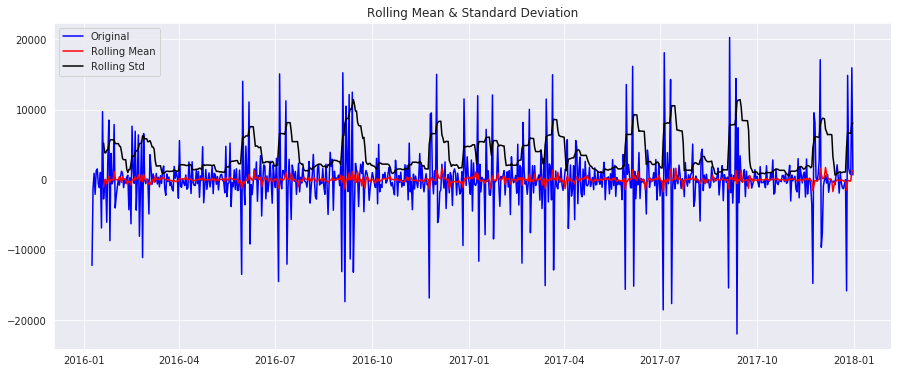

Results of Dickey-Fuller Test:
Test Statistic                -9.747981e+00
p-value                        8.158484e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


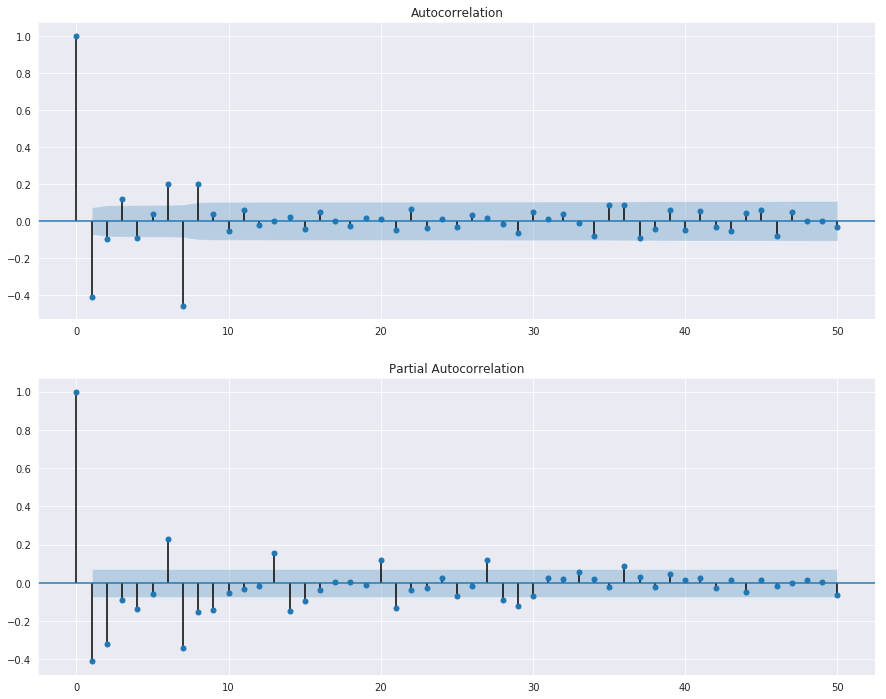

In [258]:
#df_merged['delex_diff1'] = smooth_log_diff(df_merged['delex'], lag=7)
#boxcox_result = smooth_transform(df_merged['delex'], diff_lag=7, boxcox=False)
df_t['delex'] = smooth_diff(df_merged['delex'], diff_lag=7)
df_t['delex'] = smooth_diff(df_t['delex'], diff_lag=1)
#shifts['delex'] = boxcox_result[1]
#lmbdas['delex'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['delex']))

### Transit Passengers (entering the station)
#### lag = 7, 1

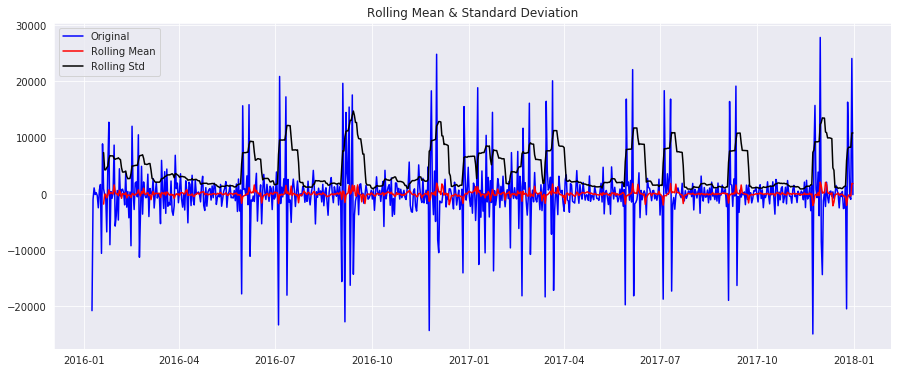

Results of Dickey-Fuller Test:
Test Statistic                -9.531277e+00
p-value                        2.886365e-16
#Lags Used                     2.000000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


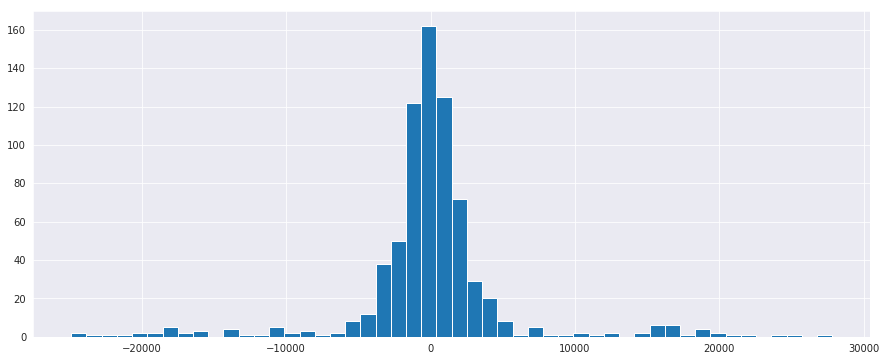

In [259]:
#df_merged['delent_diff1'] = smooth_log_diff(df_merged['delent'], lag=7)
#boxcox_result = smooth_transform(df_merged['delent'], diff_lag=7, boxcox=False)
df_t['delent'] = smooth_diff(df_merged['delent'], diff_lag=7)
df_t['delent'] = smooth_diff(df_t['delent'], diff_lag=1)
#shifts['delent'] = boxcox_result[1]
#lmbdas['delent'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['delent']))

### Cab Rides
#### lag = 7, 1

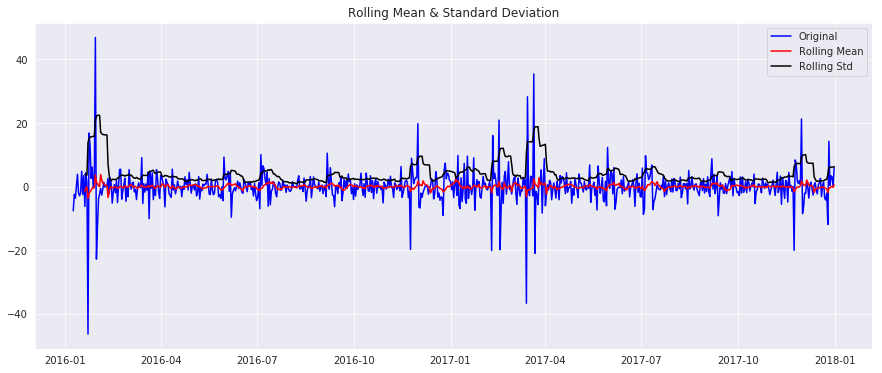

Results of Dickey-Fuller Test:
Test Statistic                -1.081283e+01
p-value                        1.889542e-19
#Lags Used                     2.000000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


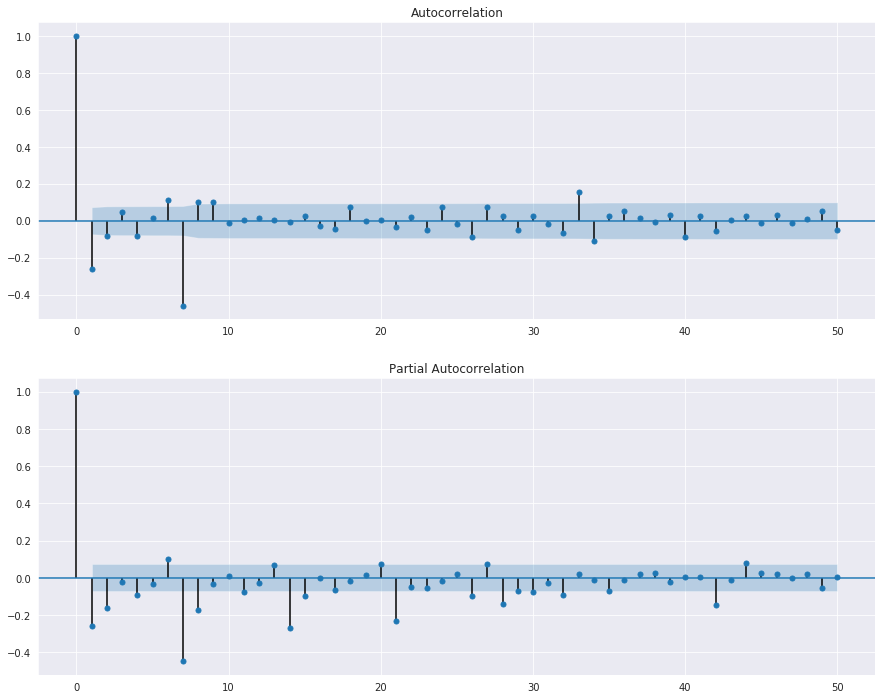

In [260]:
#df_merged['cabs_diff1'] = smooth_log_diff(df_merged['passengers'], lag=7)
#boxcox_result = smooth_transform(df_merged['passengers'], diff_lag=7, boxcox=False)
df_t['cabs'] = smooth_diff(df_merged['passengers'], diff_lag=7)
df_t['cabs'] = smooth_diff(df_t['cabs'], diff_lag=1)
#shifts['cabs'] = boxcox_result[1]
#lmbdas['cabs'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['cabs']))

### Traffic Speed
#### lag = 1

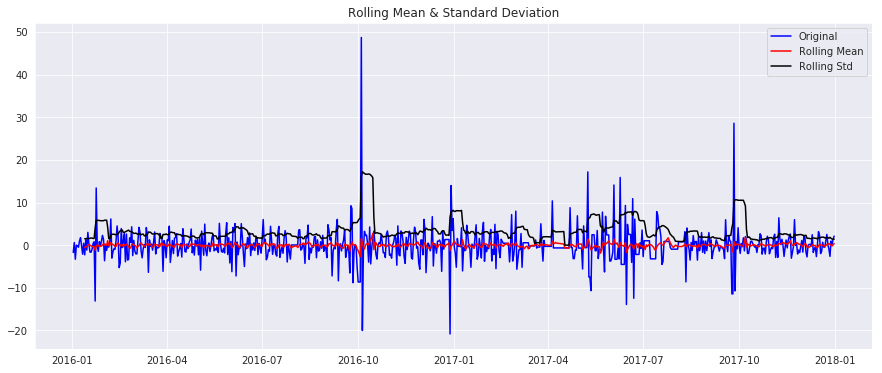

Results of Dickey-Fuller Test:
Test Statistic                -1.262513e+01
p-value                        1.547570e-23
#Lags Used                     1.200000e+01
Number of Observations Used    7.170000e+02
Critical Value (1%)           -3.439503e+00
Critical Value (5%)           -2.865579e+00
Critical Value (10%)          -2.568921e+00
dtype: float64


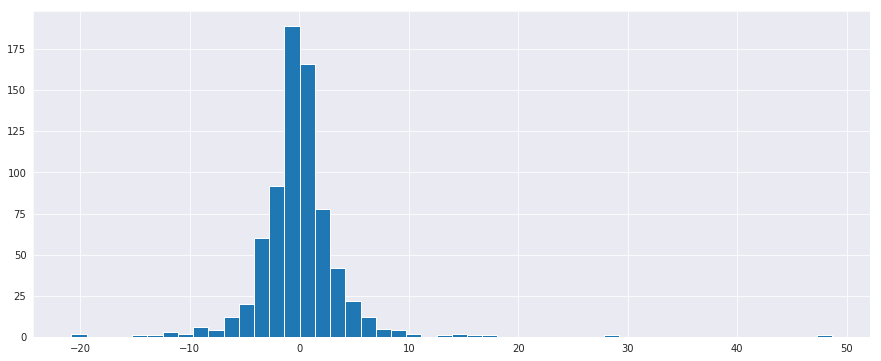

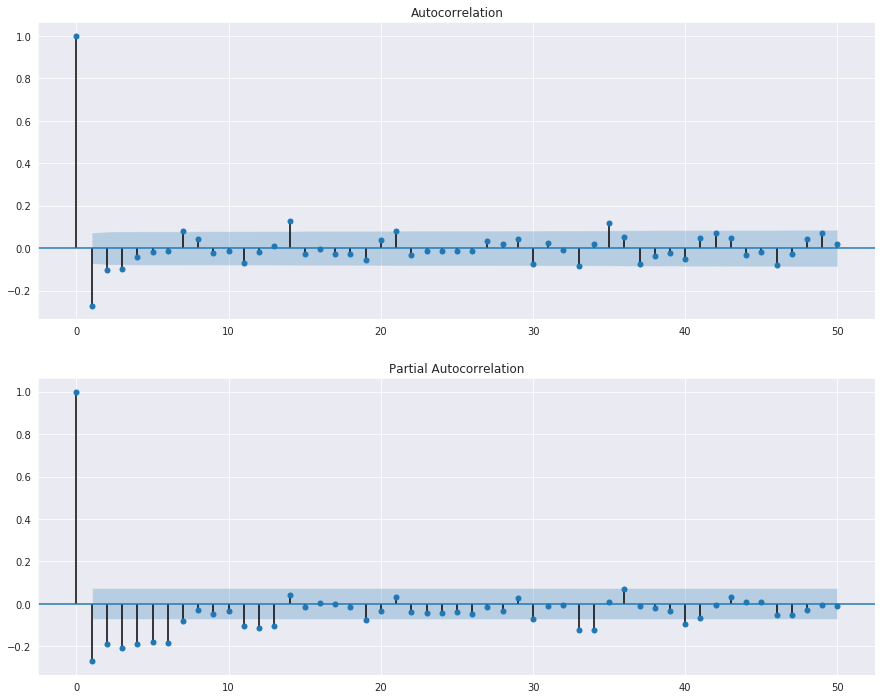

In [261]:
#df_merged['traffic_diff1'] = smooth_log_diff(df_merged['speed'], lag=7)
#boxcox_result = smooth_transform(df_merged['speed'], diff_lag=7, boxcox=False)
df_t['traffic'] = smooth_diff(df_merged['speed'], diff_lag=1)
#shifts['traffic'] = boxcox_result[1]
#lmbdas['traffic'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['traffic']))

### Gas Price

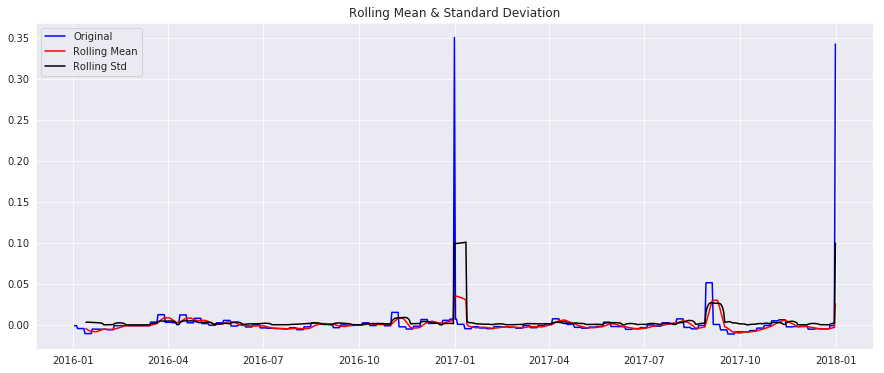

Results of Dickey-Fuller Test:
Test Statistic                -8.599246e+00
p-value                        6.940987e-14
#Lags Used                     2.000000e+00
Number of Observations Used    7.270000e+02
Critical Value (1%)           -3.439377e+00
Critical Value (5%)           -2.865524e+00
Critical Value (10%)          -2.568891e+00
dtype: float64


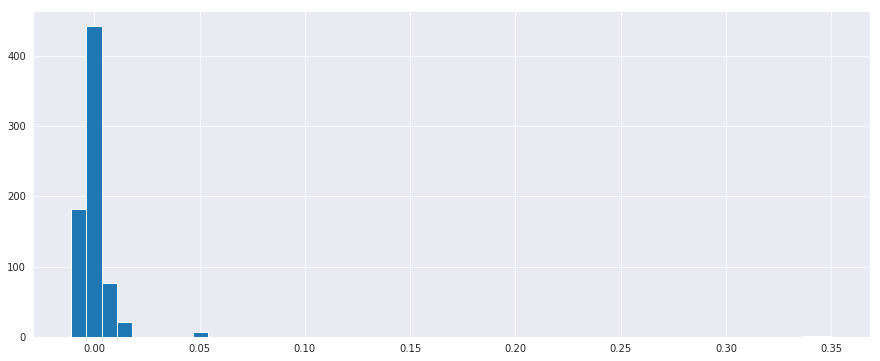

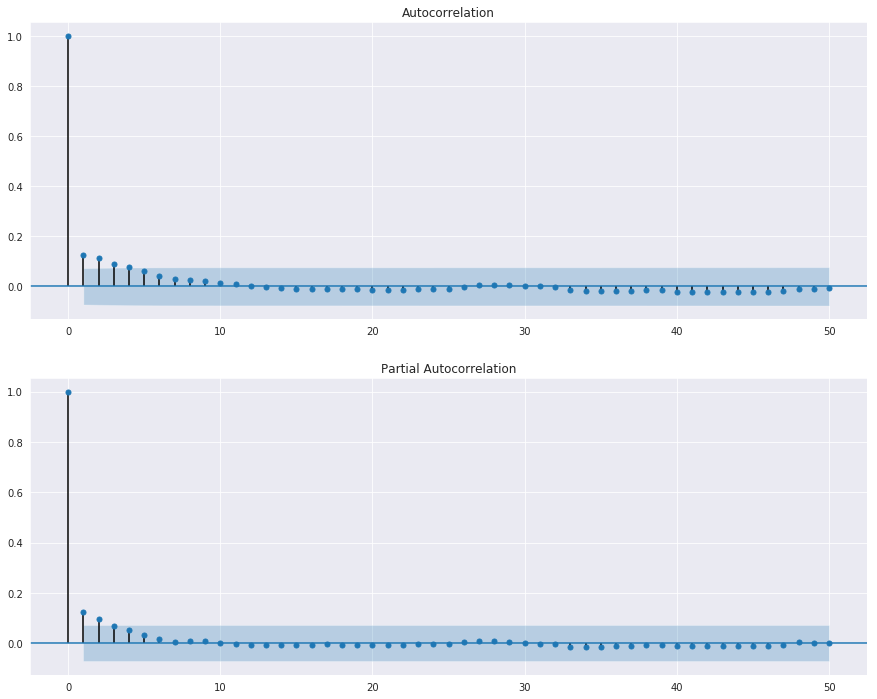

In [326]:
df_t['gas'] = smooth_poly(df_merged['price'], degree=2)
#boxcox_result = smooth_transform(df_t['gas'], diff_lag=7, boxcox=True)
df_t['gas'] = smooth_diff(df_t['gas'], diff_lag=1)
#df_t['gas'] = smooth_diff(df_t['gas'], diff_lag=8)
#df_t['gas'] = smooth_diff(df_t['gas'], diff_lag=9)
#df_t['gas'] = smooth_diff(df_t['gas'], diff_lag=32)
#shifts['gas'] = boxcox_result[1]
#lmbdas['gas'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['gas']))

### Weather Temperature

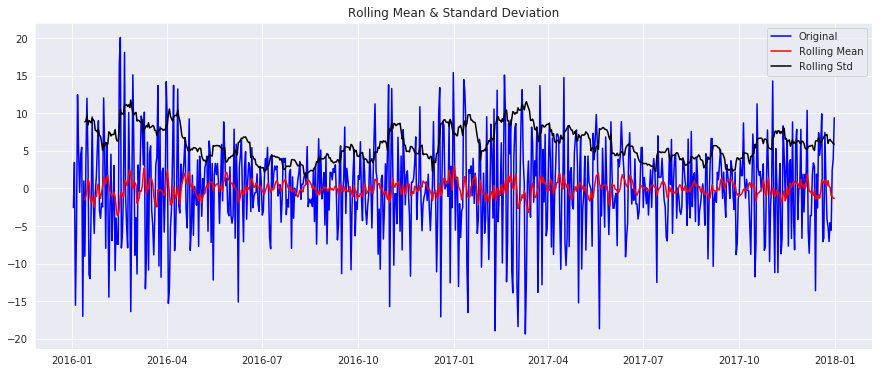

Results of Dickey-Fuller Test:
Test Statistic                -1.075841e+01
p-value                        2.557706e-19
#Lags Used                     1.500000e+01
Number of Observations Used    7.140000e+02
Critical Value (1%)           -3.439542e+00
Critical Value (5%)           -2.865596e+00
Critical Value (10%)          -2.568930e+00
dtype: float64


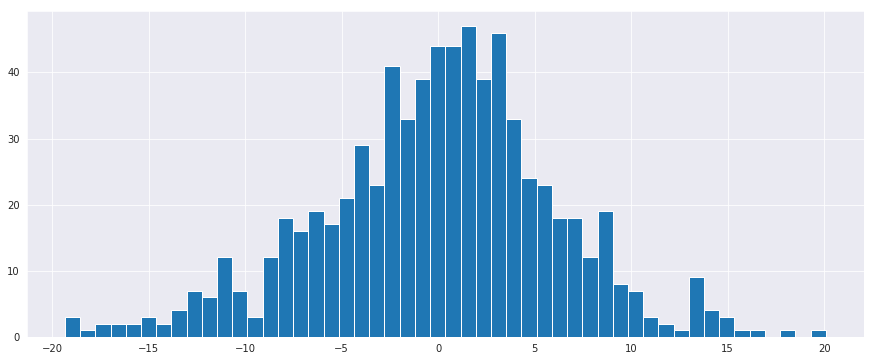

In [330]:
df_t['weather'] = smooth_poly(df_merged['temp'], degree=2)
#boxcox_result = smooth_transform(df_merged['temp'], diff_lag=7, boxcox=False)
df_t['weather'] = smooth_diff(df_t['weather'], diff_lag=1)
#shifts['weather'] = boxcox_result[1]
#lmbdas['weather'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['weather']))

### Train-Test Split

In [332]:
def interpolate_inf_na(df):
    df = df.replace([inf, -inf], nan).interpolate('time', limit_direction='both')
    return df    

In [333]:
df_t.loc[df_t.isin([inf,nan]).any(axis=1)]

delex   delent      cabs  traffic  gas  weather
2016-01-01 -12213.0 -20744.0 -7.614122 -1.71835  NaN      NaN

In [334]:
df_t = interpolate_inf_na(df_t)
df_t.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 6 columns):
delex      731 non-null float64
delent     731 non-null float64
cabs       731 non-null float64
traffic    731 non-null float64
gas        731 non-null float64
weather    731 non-null float64
dtypes: float64(6)
memory usage: 60.0 KB


In [335]:
train = df_t.loc[:'2017-06-30'][['delex','delent', 'cabs', 'traffic', 'gas', 'weather']]
test = df_t.loc['2017-07-01':][['delex','delent', 'cabs', 'traffic', 'gas', 'weather']]

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2016-01-01 to 2017-06-30
Freq: D
Data columns (total 6 columns):
delex      547 non-null float64
delent     547 non-null float64
cabs       547 non-null float64
traffic    547 non-null float64
gas        547 non-null float64
weather    547 non-null float64
dtypes: float64(6)
memory usage: 29.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2017-07-01 to 2017-12-31
Freq: D
Data columns (total 6 columns):
delex      184 non-null float64
delent     184 non-null float64
cabs       184 non-null float64
traffic    184 non-null float64
gas        184 non-null float64
weather    184 non-null float64
dtypes: float64(6)
memory usage: 10.1 KB


In [336]:
train_y = train[['delex','delent']]
train_x = train[['cabs', 'traffic', 'gas', 'weather']]
test_y = test[['delex','delent']]
test_x = test[['cabs', 'traffic', 'gas', 'weather']]

### Applying VAR Model

In [337]:
def make_var_plots(var_result, index=0):
    #fig, ax = plt.subplots(figsize=(15,12))
    var_result.plot_diagnostics(variable=index, figsize=(15,12))
    return

In [338]:
from statsmodels.tsa.statespace.varmax import VARMAX

### Model Selection

In [339]:
from numpy import zeros
p_max = 5
q_max =5
aic = DataFrame(zeros((p_max,q_max), dtype=float))
bic = DataFrame(zeros((p_max,q_max), dtype=float))
for p in range(1,p_max+1):
    for q in range(1,q_max+1):
        var_model = VARMAX(train_y, train_x, order=(p,q),  enforce_invertibility=True)
        try:
            var_model_result = var_model.fit(maxiter=100, disp=False)
            #print('order = {:d},{:d}'.format(p,q))
            aic.iloc[p-1,q-1] = var_model_result.aic
            bic.iloc[p-1,q-1] = var_model_result.bic
        except:
            aic.iloc[p-1,q-1] = nan
            bic.iloc[p-1,q-1] = nan

In [340]:
q = aic.min().idxmin()
p = aic.idxmin()[q]
print('optimum order = {:d},{:d}'.format(p,q))

optimum order = 3,4


In [341]:
var_model = VARMAX(train_y, train_x, order=(p,q),  enforce_invertibility=True)
var_model_result = var_model.fit(maxiter=5000, disp=False)
print(var_model_result.summary())

                            Statespace Model Results                           
Dep. Variable:     ['delex', 'delent']   No. Observations:                  547
Model:                     VARMAX(3,4)   Log Likelihood              -10236.503
                           + intercept   AIC                          20555.005
Date:                 Tue, 20 Nov 2018   BIC                          20731.488
Time:                         09:45:36   HQIC                         20623.988
Sample:                     01-01-2016                                         
                          - 06-30-2017                                         
Covariance Type:                   opg                                         
Ljung-Box (Q):                42.28, 70.85   Jarque-Bera (JB):        175.89, 36.61
Prob(Q):                        0.37, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.04, 0.80   Skew:                     -0.05, -0.01
Prob(H) (two-sided):        

### Heteroskedasticity
#### (null hypothesis - no heteroskedasticity, variance not changing throughout sample)

In [342]:
h_test = var_model_result.test_heteroskedasticity(method=None)
print('Transit Passengers (exiting the station) :')
print('t-statistic ', h_test[0][0])
print('p-value     ', h_test[0][1])
print('')
print('Transit Passengers (entering the station) :')
print('t-statistic ', h_test[1][0])
print('p-value     ', h_test[1][1])

Transit Passengers (exiting the station) :
t-statistic  1.0405158873780296
p-value      0.7890635586073371

Transit Passengers (entering the station) :
t-statistic  0.8040414945169765
p-value      0.142178929735286


### Transit Passengers (exiting the station)

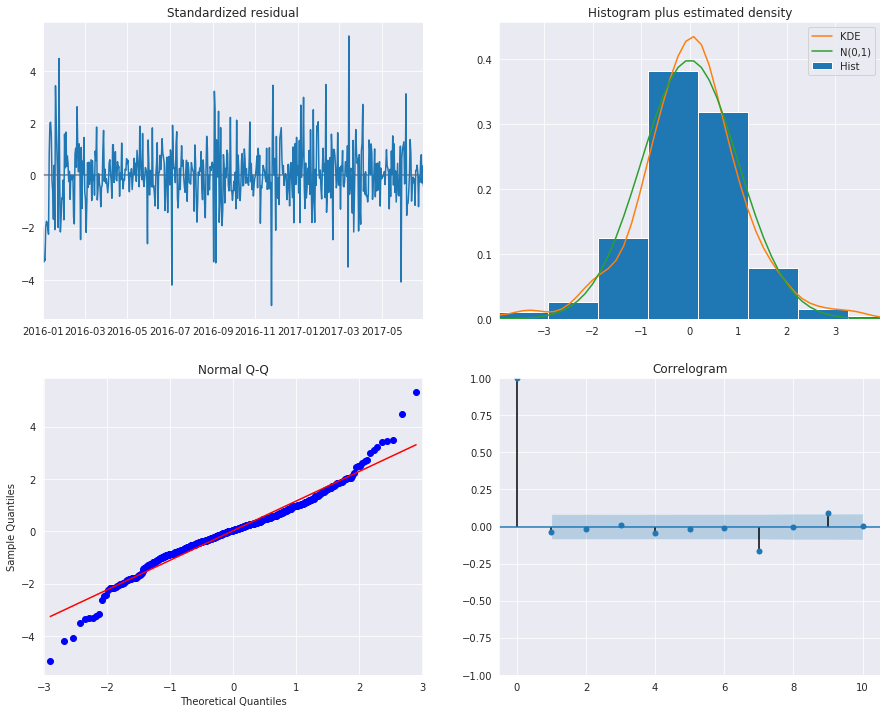

In [343]:
make_var_plots(var_model_result, index=0)

### Transit Passengers (entering the station)

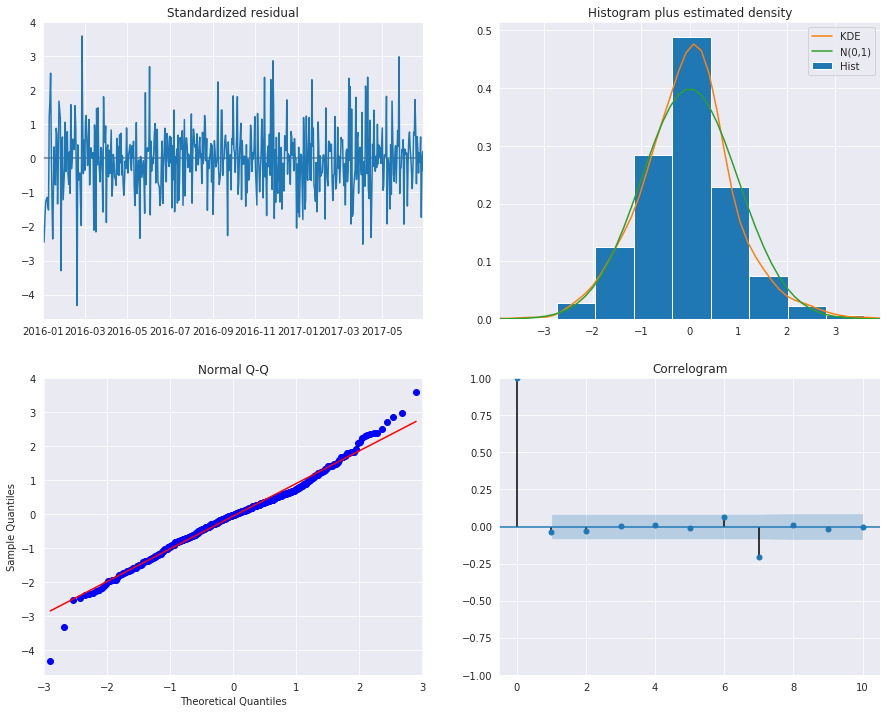

In [344]:
make_var_plots(var_model_result, index=1)

### Forecasting

In [345]:
# Generate Exogenous Data for Forecasting
nforecast = len(test_x)
print('no. of training observations ',var_model_result.nobs)
print('no. of data-points to be forecast ',nforecast)

no. of training observations  547
no. of data-points to be forecast  184


In [346]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
predict = var_model_result.get_prediction(end=var_model_result.nobs + nforecast-1, exog = test_x)
""" idx = np.arange(len(predict.predicted_mean)) """
predict_ci95 = predict.conf_int(alpha=0.05)
predict_ci60 = predict.conf_int(alpha=0.4)
predict_ci30 = predict.conf_int(alpha=0.7)

In [347]:
pred_mean = predict.predicted_mean

### Inverse Transformation

#### Inverse Transform for single diff

$$\dot y_t = y_t - y_{t-lag}$$

$$y_t = \dot y_t + y_{t-lag}$$

In [348]:
# inverse diff
def inverse_diff(y_hat_trnsfmd, y_init, diff_lag):
    df = DataFrame(y_hat_trnsfmd.values, columns=['y_hat_trnsfmd'])
    init_len = diff_lag
    df = df.iloc[init_len:]
    df_init = DataFrame(y_init.values, columns=['y_hat_trnsfmd'])
    df = concat([df_init, df])
    df['y_hat'] = df['y_hat_trnsfmd']
    for idx in df.index:
        if idx >= diff_lag:
            df['y_hat'].iloc[idx] = df['y_hat_trnsfmd'].iloc[idx] + df['y_hat'].iloc[idx-diff_lag]
    df.index = y_hat_trnsfmd.index
    return df['y_hat']

#### Inverse Transform for double diff

$$\dot y_t = y_t - y_{t-lag1}$$
$$\ddot y_t = \dot y_t - \dot y_{t-lag2}$$

$$y_t = \dot y_t + y_{t-lag1}
      = \ddot y_t + \dot y_{t-lag2} + y_{t-lag1}
      = \ddot y_t + y_{t-lag1} + y_{t-lag2} - y_{t-lag2-lag1}$$

In [349]:
# inverse double diff
def inverse_dbl_diff(y_hat_trnsfmd, y_init, diff_lag1, diff_lag2):
    df = DataFrame(y_hat_trnsfmd.values, columns=['y_hat_trnsfmd'])
    init_len = diff_lag1+diff_lag2
    df = df.iloc[init_len:]
    df_init = DataFrame(y_init.values, columns=['y_hat_trnsfmd'])
    df = concat([df_init, df])
    df['y_hat'] = df['y_hat_trnsfmd']
    for idx in df.index:
        if idx >= (diff_lag1+diff_lag2):
            df['y_hat'].iloc[idx] = df['y_hat_trnsfmd'].iloc[idx] + df['y_hat'].iloc[idx-diff_lag1] + df['y_hat'].iloc[idx-diff_lag2] - df['y_hat'].iloc[idx-diff_lag2-diff_lag1]
    df.index = y_hat_trnsfmd.index
    return df['y_hat']

In [350]:
from pandas import Timedelta
y_cols = ['delex','delent']
lag1=7
lag2=1
idx0 = df_merged.index.to_series().iloc[0]
pred_mean_inv = DataFrame(index=pred_mean.index, columns=y_cols)
td = Timedelta(lag1+lag2-1, unit='d')
initial_idx = (idx0+td).strftime('%Y-%m-%d')
for col in y_cols:
        pred_mean_inv[col] = inverse_dbl_diff(pred_mean[col], df_merged[col].loc[:initial_idx], diff_lag1=lag1, diff_lag2=lag2)          
pred_mean_inv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 2 columns):
delex     731 non-null float64
delent    731 non-null float64
dtypes: float64(2)
memory usage: 17.1 KB


In [351]:
#pred_mean_inv.loc[pred_mean_inv.isna().any(axis=1)]
pred_mean_inv.describe()

delex        delent
count  7.310000e+02  7.310000e+02
mean  -2.758286e+06 -2.726922e+06
std    2.319318e+06  2.224586e+06
min   -7.664781e+06 -7.464921e+06
25%   -4.645105e+06 -4.503525e+06
50%   -2.060670e+06 -2.169042e+06
75%   -6.794096e+05 -7.292677e+05
max    2.418300e+04  3.355000e+04

In [352]:
df_merged[['delex', 'delent']].describe()

delex        delent
count    731.000000    731.000000
mean   17897.768810  23779.637483
std     7224.454058  10028.378301
min     2382.000000   4065.000000
25%     9422.500000  12066.500000
50%    21870.000000  29331.000000
75%    22880.500000  31112.500000
max    29611.000000  35219.000000

In [353]:
def make_prediction_plot(df, train_y, test_y, predict, y_column, days_to_skip=1):    
    td_skip = Timedelta(days_to_skip-1, unit='d')
    idx0 = df.index.to_series().iloc[0] + td_skip
    start_idx = idx0.strftime('%Y-%m-%d')
    train_y = train_y.loc[start_idx:]
    
    train_y = df.loc[train_y.index][[y_column]]
    test_y = df.loc[test_y.index][[y_column]]
    nforecast = len(test_y)
    df = concat([train_y, test_y])
    idx = df.index
    # Graph
    fig, ax = plt.subplots(figsize=(18,10))
    ax.grid()
    ax.plot(idx,df,'k',label='', alpha=1, linewidth=0.75)
    ax.plot(idx,df,'k.', label='Actual Values', alpha=1, linewidth=0.75)
    
    pred_mean=predict.predicted_mean.loc[start_idx:][[y_column]]
    lag=7
    td = Timedelta(lag-1, unit='d')
    initial_idx = (idx0+td).strftime('%Y-%m-%d')
    pred_mean_inv = DataFrame(index=pred_mean.index, columns=[y_column])
    pred_mean_inv[y_column] = inverse_diff(pred_mean[y_column], df[y_column].loc[:initial_idx], diff_lag=lag)
    offset = pred_mean_inv[y_column] - pred_mean[y_column]
    #offset=0
    predict_ci95 = predict.conf_int(alpha=0.05).loc[start_idx:]
    predict_ci60 = predict.conf_int(alpha=0.4).loc[start_idx:]
    predict_ci30 = predict.conf_int(alpha=0.7).loc[start_idx:]
    lower = 'lower '+y_column
    upper = 'upper '+y_column
    predict_ci95_lower = predict_ci95[lower] + offset
    predict_ci60_lower = predict_ci60[lower] + offset
    predict_ci30_lower = predict_ci30[lower] + offset
    predict_ci95_upper = predict_ci95[upper] + offset
    predict_ci60_upper = predict_ci60[upper] + offset
    predict_ci30_upper = predict_ci30[upper] + offset
    
    # Plot
    ax.plot(train_y.index, pred_mean_inv[:-nforecast], color='blue',alpha=0.7, label='Train-Set Prediction')
    ax.plot(test_y.index, pred_mean_inv[-nforecast:], 'k--', color='red', alpha=0.7, linestyle='--', linewidth=1.5,label='Test-Set Prediction')
    
    #if inverse_trans_func is None:
    ax.fill_between(test_y.index, predict_ci95_lower.iloc[-nforecast:], 
                    predict_ci95_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.fill_between(test_y.index, predict_ci60_lower.iloc[-nforecast:], 
                    predict_ci60_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.fill_between(test_y.index, predict_ci30_lower.iloc[-nforecast:], 
                    predict_ci30_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.legend()
    ax.set(title='VARMAX - Forecasting');
    plt.show(fig)

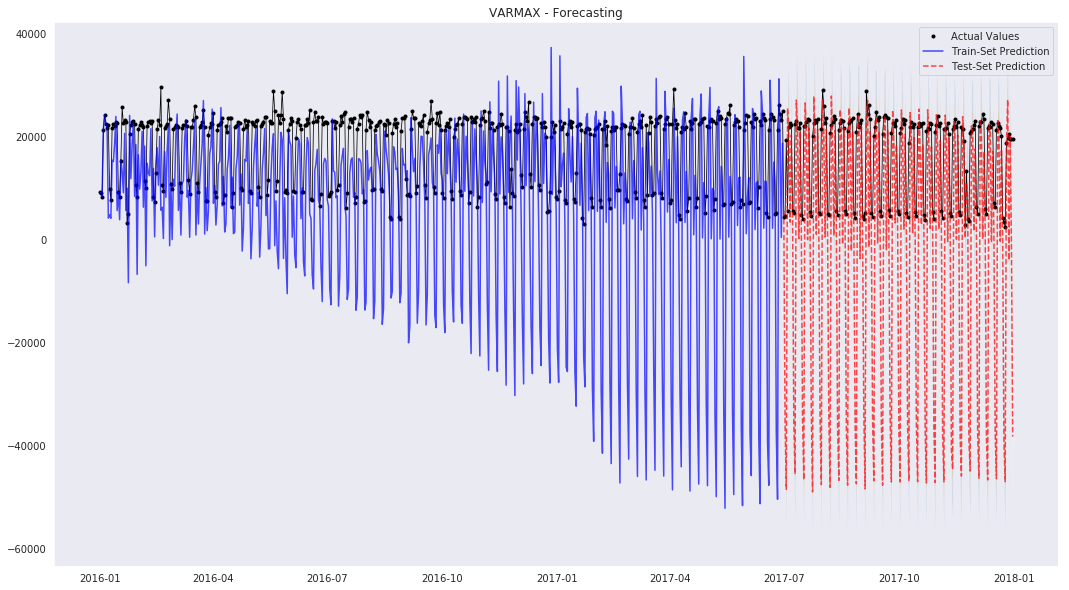

In [354]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delex')

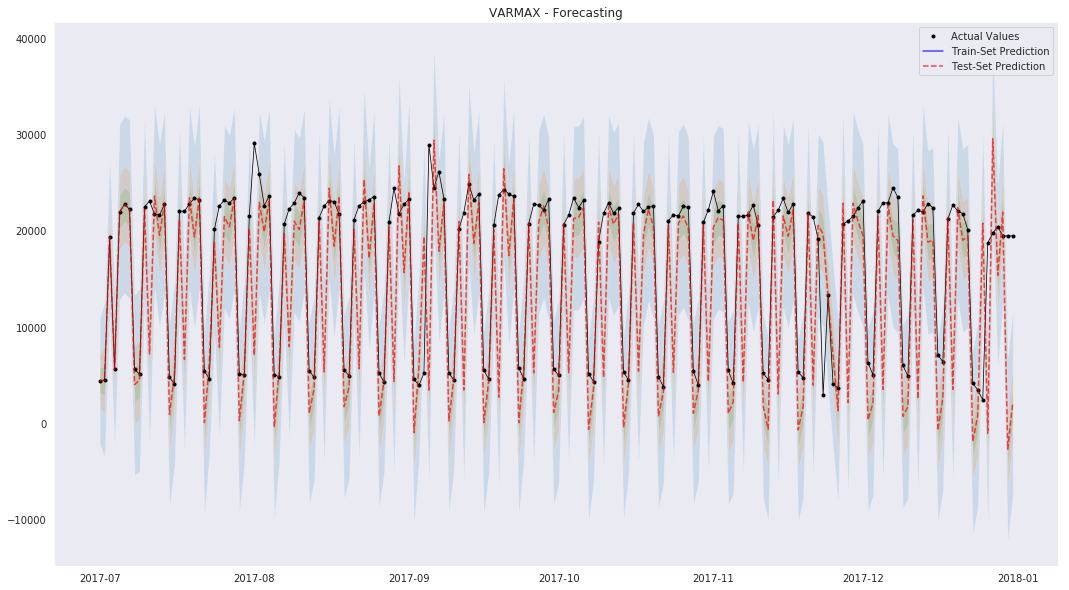

In [355]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delex', days_to_skip=548)

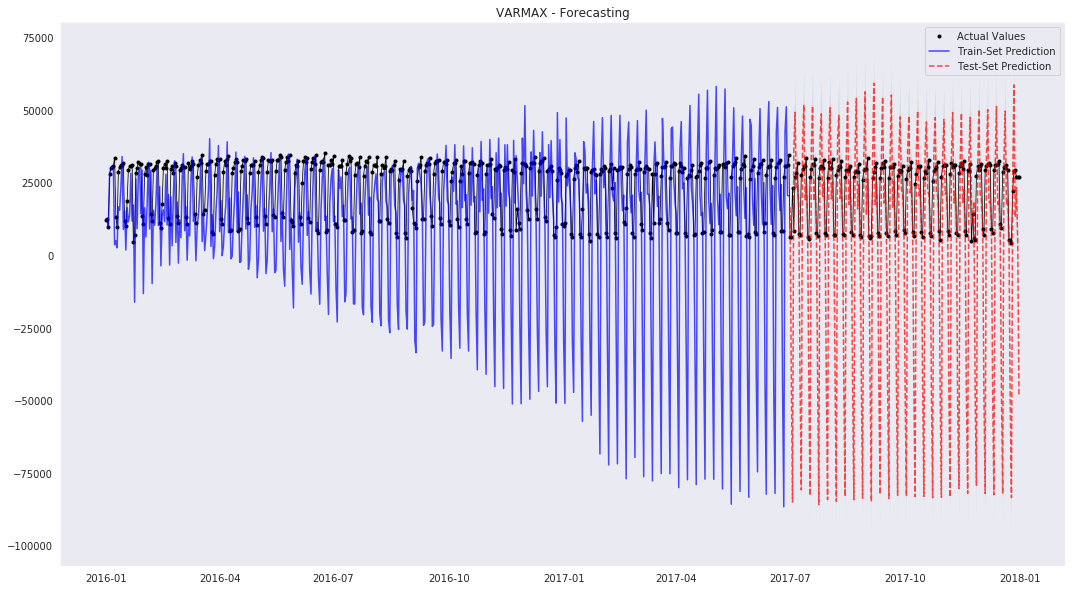

In [356]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delent')

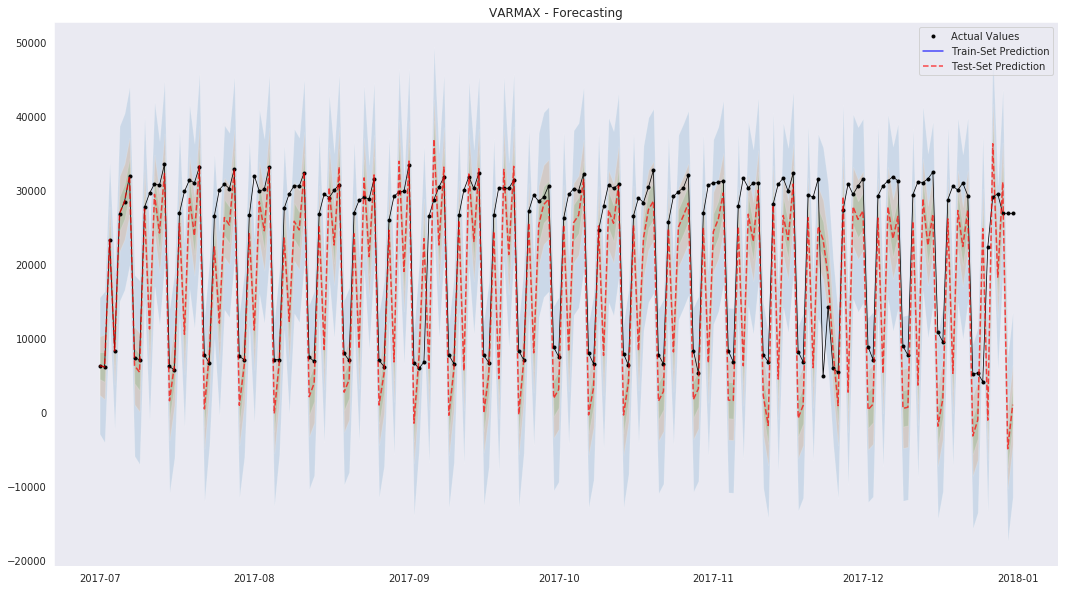

In [357]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delent', days_to_skip=548)

### Fitting a GARCH model to the VARMAX residuals

In [358]:
from pyflux import GARCH

In [359]:
def optimize_garch(data, var_col, p_max=5, q_max=5):
    aic = DataFrame(zeros((p_max,q_max), dtype=float))
    bic = DataFrame(zeros((p_max,q_max), dtype=float))
    for p in range(1,p_max+1):
        for q in range(1,q_max+1):
            garch_model = GARCH(data, p=p, q=q, target=var_col)
            try:
                garch_model_result = garch_model.fit()
                aic.iloc[p-1,q-1] = garch_model_result.aic
                bic.iloc[p-1,q-1] = garch_model_result.bic
            except:
                aic.iloc[p-1,q-1] = nan
                bic.iloc[p-1,q-1] = nan
    q = aic.min().idxmin()
    p = aic.idxmin()[q]
    return p, q

#### Transit Passengers (exiting)

In [360]:
p_delex, q_delex = optimize_garch(var_model_result.resid, var_col='delex')
print('optimum order for passsengers exiting (delex)= {:d},{:d}'.format(p_delex,q_delex))

optimum order for passsengers exiting (delex)= 0,4


In [361]:
garch_model = GARCH(var_model_result.resid, p=p_delex, q=q_delex, target='delex')
garch_model_result = garch_model.fit()
garch_model_result.summary(transformed=False)

Hessian not invertible! Consider a different model specification.

GARCH(0,4)                                                                                                
======================================================= ==================================================
Dependent Variable: delex                               Method: MLE                                       
Start Date: 2016-01-05 00:00:00                         Log Likelihood: -5349.6304                        
End Date: 2017-06-30 00:00:00                           AIC: 10711.260831305388                           
Number of observations: 543                             BIC: 10737.043487224992                           
Latent Variable                          Estimate  
======================================== ==========
Vol Constant                             0.0009    
q(1)                                     0.5038    
q(2)                                     1.0       
q(3)                           

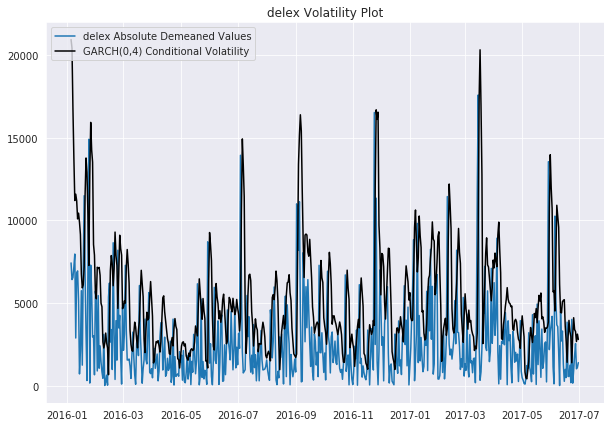

In [362]:
garch_model.plot_fit()

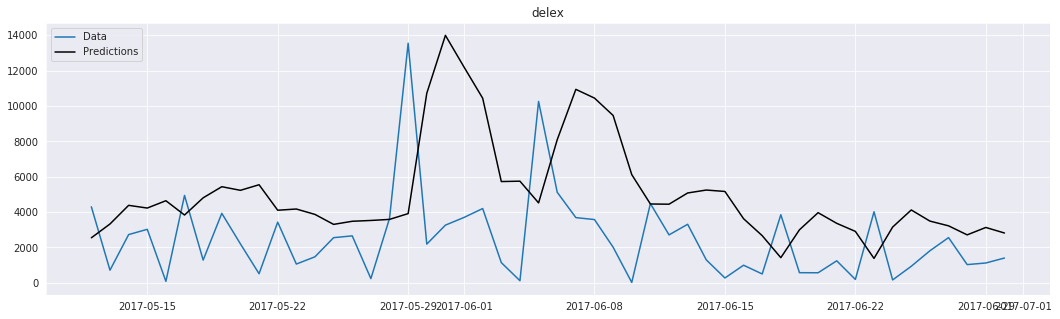

In [363]:
garch_model.plot_predict_is(h=50, figsize=(18,5))

#### Transit Passengers (entering)

In [364]:
p_delent, q_delent = optimize_garch(var_model_result.resid, var_col='delent')
print('optimum order for passengers entering (delent)= {:d},{:d}'.format(p_delent,q_delent))

optimum order for passengers entering (delent)= 0,4


In [365]:
garch_model = GARCH(var_model_result.resid, p=p_delent, q=q_delent, target='delent')
garch_model_result = garch_model.fit()
garch_model_result.summary()

Hessian not invertible! Consider a different model specification.

GARCH(0,4)                                                                                                
======================================================= ==================================================
Dependent Variable: delent                              Method: MLE                                       
Start Date: 2016-01-05 00:00:00                         Log Likelihood: -5457.9211                        
End Date: 2017-06-30 00:00:00                           AIC: 10927.84224117203                            
Number of observations: 543                             BIC: 10953.624897091633                           
Latent Variable                          Estimate  
======================================== ==========
Vol Constant                             0.0009    
q(1)                                     1.0       
q(2)                                     0.5295    
q(3)                           

### Dynamic Linear Regression

In [366]:
from pyflux import DynReg, DynamicGLM

In [367]:
dyn_reg_model = DynReg('delex ~ cabs+traffic+gas+weather', data=df)
dyn_reg_model_result = dyn_reg_model.fit()
dyn_reg_model_result.summary()

Dynamic Linear Regression                                                                                 
======================================================= ==================================================
Dependent Variable: delex                               Method: MLE                                       
Start Date: 2016-01-01 00:00:00                         Log Likelihood: -5230.08                          
End Date: 2017-06-30 00:00:00                           AIC: 10472.16                                     
Number of observations: 547                             BIC: 10497.9867                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        0.2015                                                           
Sigma^2 1                            

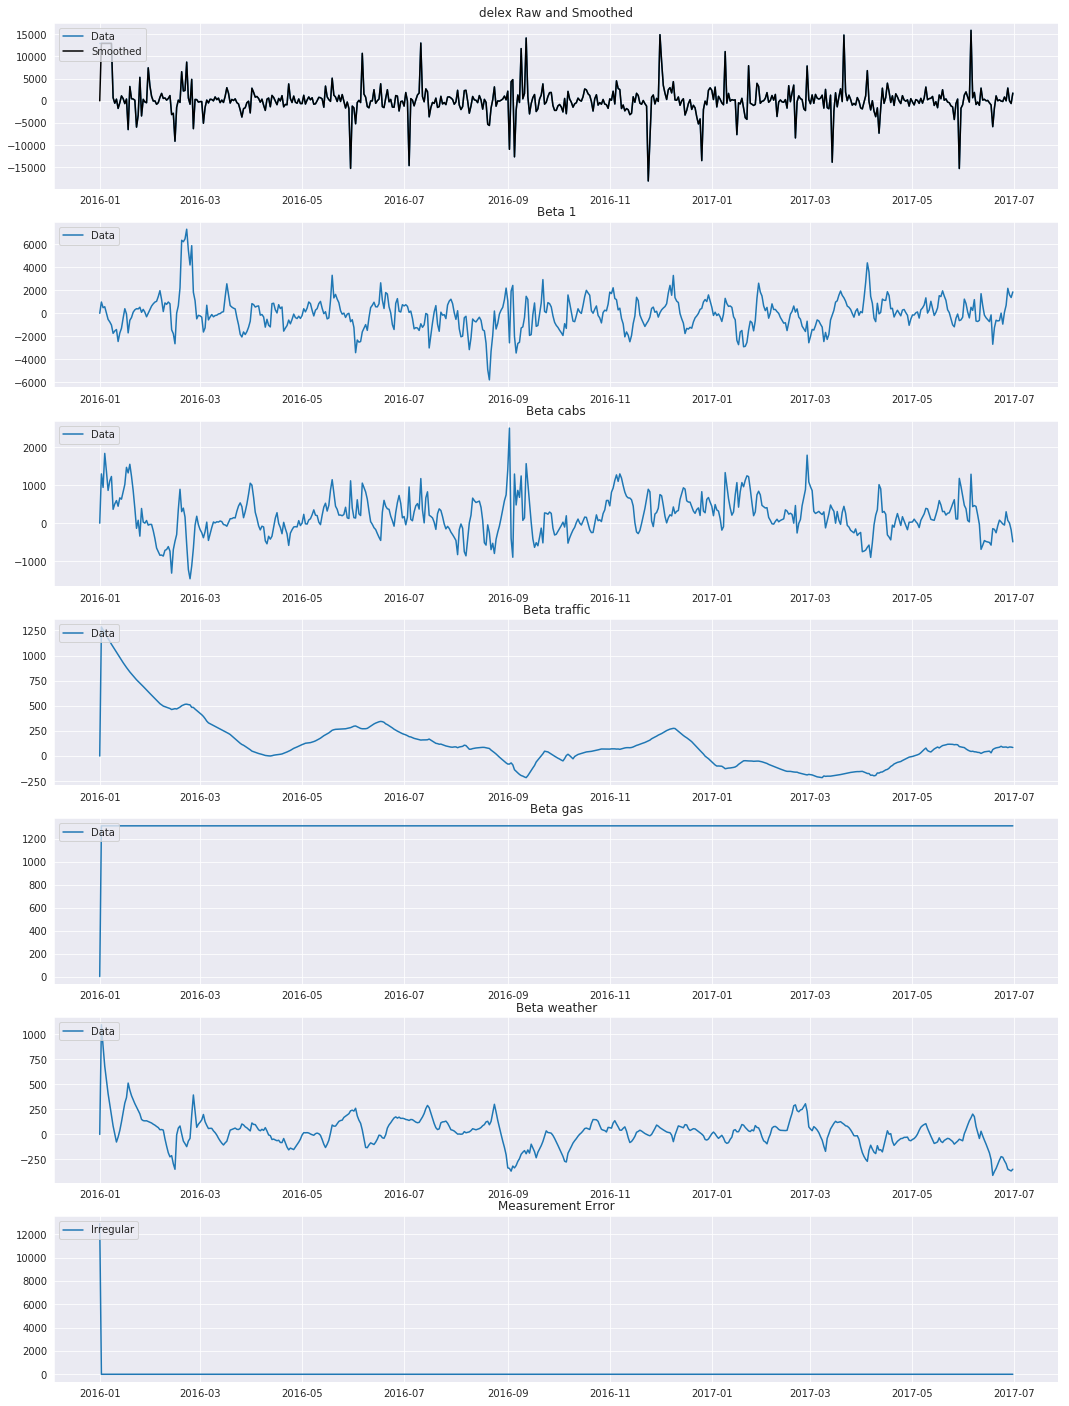

In [368]:
dyn_reg_model.plot_fit(figsize=(18,25))

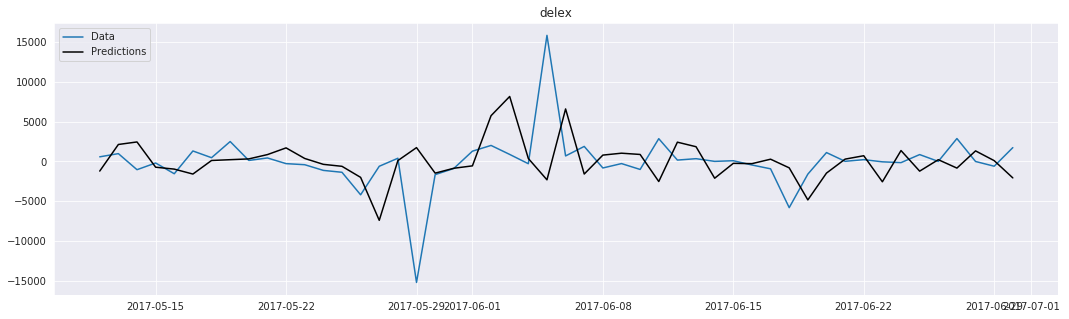

In [369]:
dyn_reg_model.plot_predict_is(h=50, figsize=(18,5))

#### Dynamic GLM

In [370]:
from pyflux import Normal
dyn_glm_model = DynamicGLM('delex ~ cabs+traffic+gas+weather', data=df, family=Normal())
dyn_glm_model_result = dyn_glm_model.fit()
dyn_glm_model_result.summary()

Dynamic Linear Regression                                                                                 
======================================================= ==================================================
Dependent Variable: delex                               Method: MLE                                       
Start Date: 2016-01-01 00:00:00                         Log Likelihood: -5230.08                          
End Date: 2017-06-30 00:00:00                           AIC: 10472.16                                     
Number of observations: 547                             BIC: 10497.9867                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        0.2015                                                           
Sigma^2 1                            

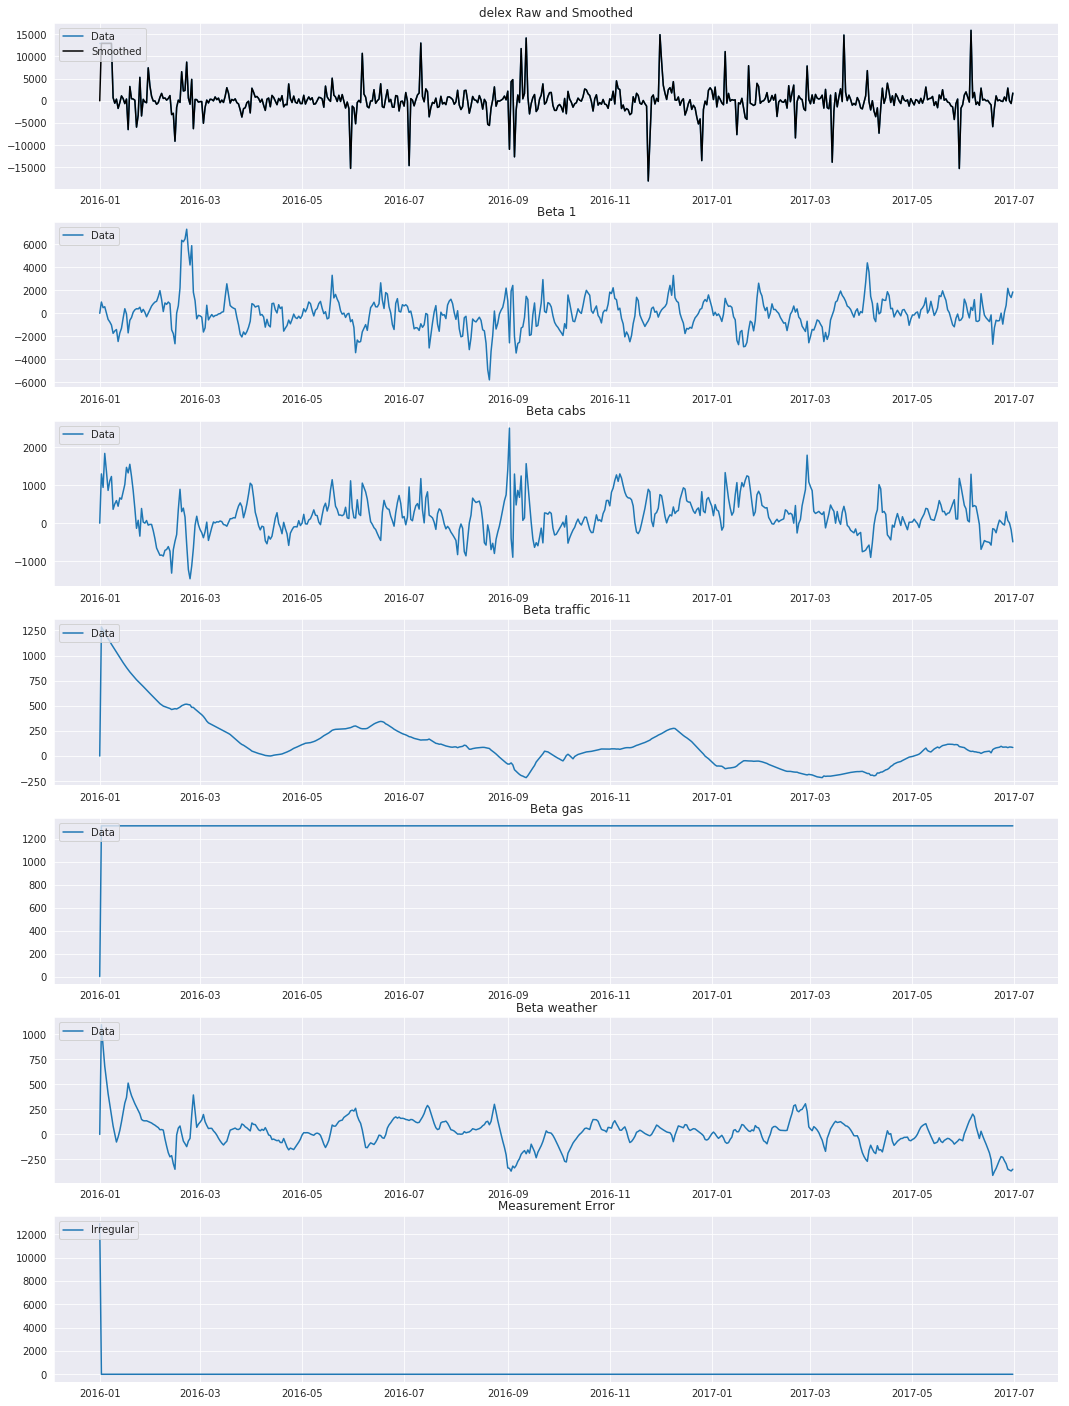

In [371]:
dyn_glm_model.plot_fit(figsize=(18,25))

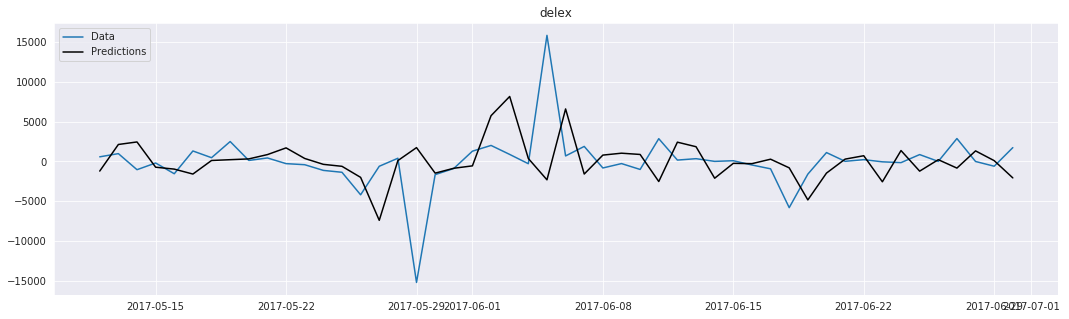

In [372]:
dyn_glm_model.plot_predict_is(h=50, figsize=(18,5))

### GAS Regression Model

In [373]:
from pyflux import GASReg, t
gas_reg_model = GASReg('delent ~ cabs+traffic+gas+weather', data=df, family=t())
gas_reg_model_result = gas_reg_model.fit()
gas_reg_model_result.summary()

t GAS Regression                                                                                          
======================================================= ==================================================
Dependent Variable: delent                              Method: MLE                                       
Start Date: 2016-01-01 00:00:00                         Log Likelihood: -5105.434                         
End Date: 2017-06-30 00:00:00                           AIC: 10224.868                                    
Number of observations: 547                             BIC: 10254.9992                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Scale 1                                  0.0067                                                           
Scale cabs                           

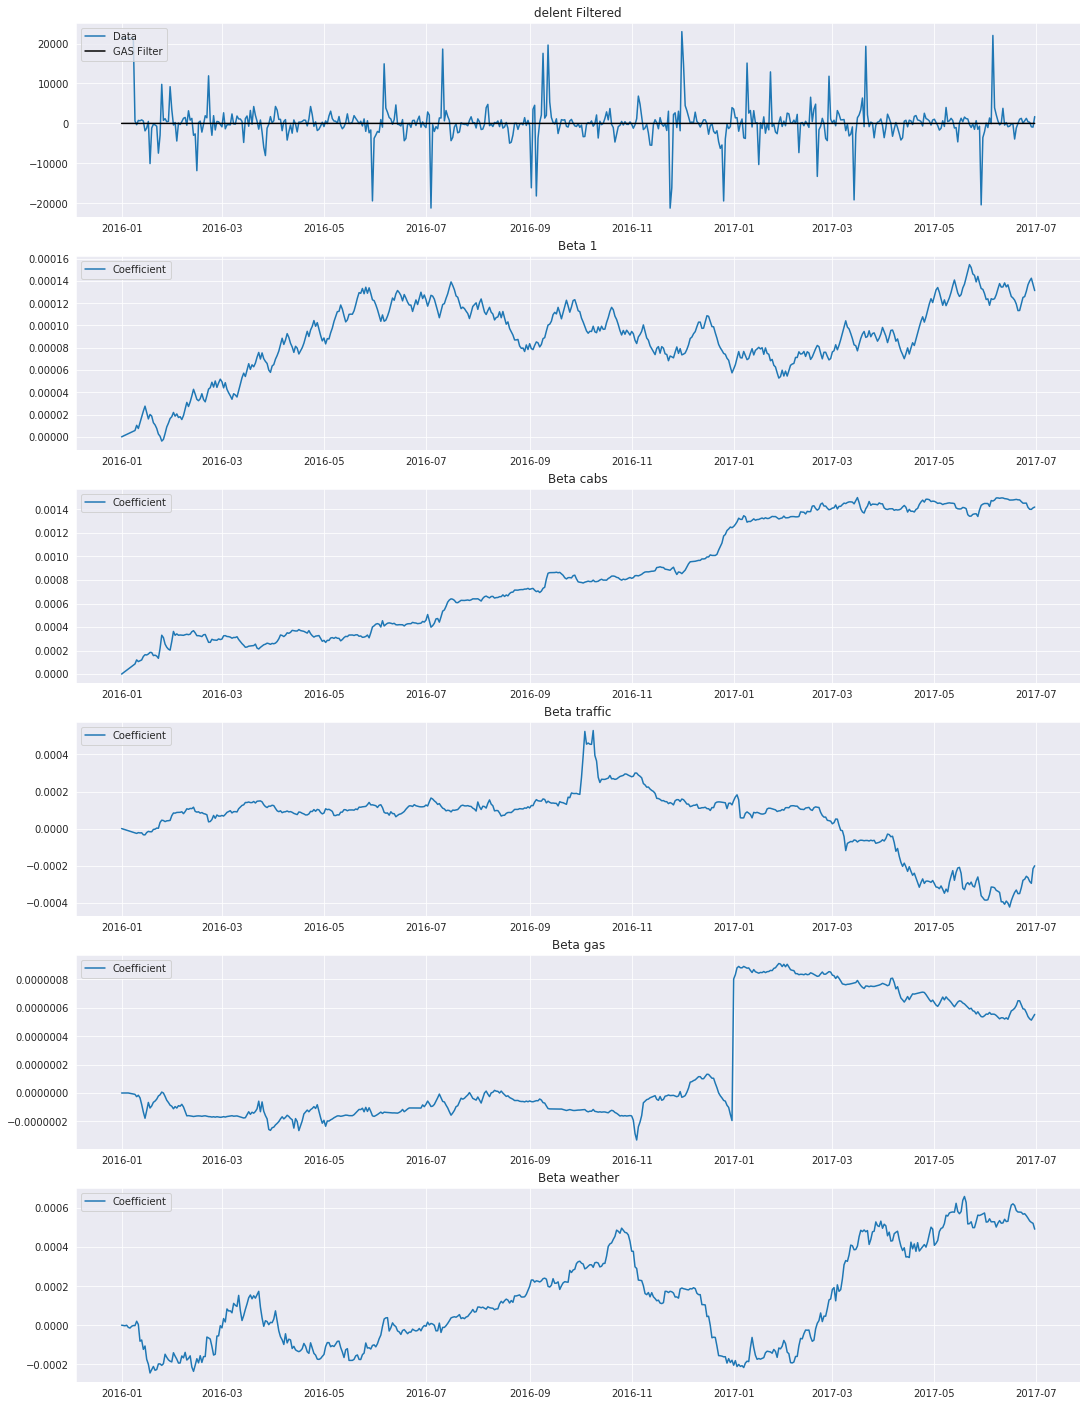

In [374]:
gas_reg_model.plot_fit(figsize=(18,25))

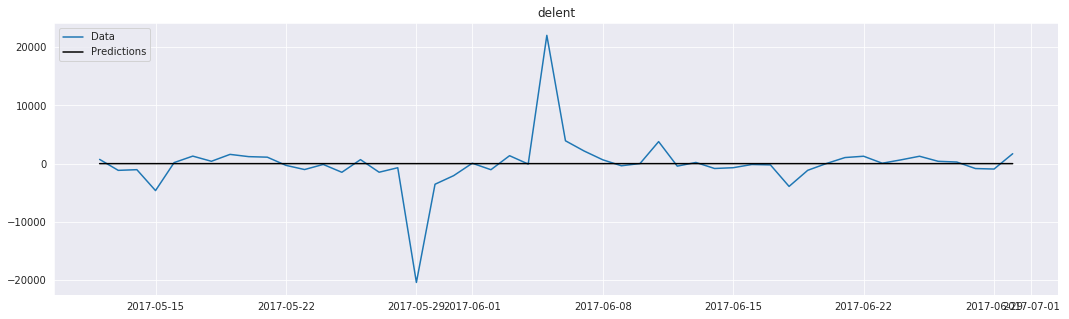

In [375]:
gas_reg_model.plot_predict_is(h=50, figsize=(18,5))